# **INTRODUCTION**

This notebook documents consumer insight analysis for [Bellabeat](https://bellabeat.com/), a wellness tech company, and as part of an individual capstone project for the [Google Data Analytics Professional Certificate Course](https://www.coursera.org/professional-certificates/google-data-analytics).  

For this analysis, we'll use SQL to validate, process, and analyze the data. For ease of documentation, we'll use the Google BigQuery API to run queries and access data from within this Jupyter Notebook. 

In addition, we'll use *Tableau* to create the data visualizations shown in this notebook, and a stand-alone visualization-driven **[high-level report](https://public.tableau.com/app/profile/phil.lin/viz/BellabeatAnalysis_16486095004470/STORY)**. 

An **[executive summary](#s1)** can be found in the **[SHARE](#s1)** section of this notebook.

The analysis presented here will be organized using the *6-step Data Analysis framework (Ask, Prepare, Processs, Analyze, Share, Act)*.

# **ASK**

## About Bellabeat
[**Bellabeat**](https://bellabeat.com/) is a tech-driven wellness company known for designing health-focused smart devices for women. Its products allow women to track their overall health and wellness throughout different stages in life helping them better understand their bodies and make informed, healthier choices. Bellabeat's core product line-up includes:

- **Leaf**: a versatile bracelet, necklace, or clip tracking activity and sleep
- **Ivy**: a bracelet tracking activity, sleep, and heart rate
- **Time**: a smart watch tracking activity and sleep
- **Spring**: a smart water bottle tracking daily water intake

All of these smart devices run a software product, **Bellabeat App**, which tracks and offers guidance on users' activity, sleep, stress, menstrual cycle, and mindfulness habits.

## Key Stakeholders

- **Urška Sršen**: Bellabeat's co-founder and Chief Creative Officer (CCO)
- **Sandro Mur**: Mathematician and Bellabeat’s co-founder and Chief Executive Officer (CEO)
- **Bellabeat Marketing Analytics Team**: A team of data analysts responsible for collecting, analyzing, and reporting data that helps guide Bellabeat’s marketing strategy. 


## Business Task
The executive team would like to understand how current consumers use non-Bellabeat smart devices and then leverage these insights to find opportunities for growth. Additionally, they would like recommendations for a marketing strategy informed by the findings of this analysis. A dataset has been provided by the Bellabeat team.


# **PREPARE**

## Data Details

The [dataset](https://www.kaggle.com/datasets/arashnic/fitbit) contains personal tracking data on a group of Fitbit users. Fitbits were one of the first wearable devices to popularize activity trackers and dominated the market prior to the rise of smart watches by companies like Apple, Samsung, and Huawei+. Data from this group may help Bellabeat gain more insight on those who may not necessarily want a watch and care about their fitness—both are areas that Bellabeat can distinguish itself from the competition.

The data originates from thirty-three Fitbit users responding to a distributed survey via Amazon Mechanical Turk from 03.12.2016 to 05.12.2016. The dataset contains 18 files covering:
- **Physical Activity** (measured in Steps, Calories, and METs (metabolic equivalents))
- **Sleep** (measured in minutes)
- **Weight/BMI** (lbs/kg)
- **Heart rate** (bpm)

While 33 unique individuals provided data for physical activity, fewer individuals contributed data in the other areas.  
- Physical Activity: 33
- Sleep monitoring: 24
- Weight: 8
- Heart rate: 14 

To narrow our focus, for this analysis we will only use data from the 30-day period 04.12.16 - 05.12.16 and data covering **Physical Activity** (daily, hourly), **Sleep** (daily), and **Weight**.

## Licensing, Privacy, Security

The data provided for this analysis is a [dataset](https://www.kaggle.com/datasets/arashnic/fitbit) in the public domain ([CC0 1.0 Universal Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)) made available on Kaggle (via user [MÖBIUS](https://www.kaggle.com/arashnic)).

All users participating in the survey consented to the submission of personal tracking data. The users' privacy has been protected by only referring to individuals via randomly generated ID numbers.

## Data Integrity

Since the data was supplied via a third party user on Kaggle, we should investigate further to find the original source.   

Looking into it, we find that the dataset originated from Zenodo, an open access research data repository developed as part of the European OpenAIRE program, which is maintained by CERN (European Organization for Nuclear Research).Authors of the survey are cited as Robert Furberg, Julia Brinton, Michael Keating, and Alexa Ortiz.

In addition, the dataset was originally published on 05.16.16 with a different license [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/legalcode).

To ensure no loss of data integrity, this analysis will work with [data from the original repository](https://doi.org/10.5281/zenodo.53894) on Zenodo.

## Data Quality


Given the specific objective of this analysis to help Bellabeat better understand existing users of smart fitness wearables, the following are some other potential concerns with this data:

- **Variation**: some of the variation in output may be due to different types of Fitbit trackers or invidiual tracking behavior/preferences.
- **Demographics**: this dataset lacks information on user demographic data (sex, age, location, etc.) that may be relevant when drawing comparisons to Bellabeat's target audience
- **Sample Bias**: the number of participants in the survey is small and only captures several weeks in one particular season of the year.  
- **Obsolescence**: the data is already five years old, and especially within the fast-moving wearables space many changes in consumer behavior may have occurred.

# **PROCESS**

During this step, we'll get to know our data by first checking for potential issues through *validation*. Then we'll clean, transform, and prepare the data for analysis by *processing* it. 

In this analysis, our *validate* and *process* steps we'll specifically include the following:
- **validate**: inspect column names, column format, data type, record count, null count, and summary stats
- **process**: convert data type, change format, transform data, and create additional columns 


## Inspect column names, column format, data type

In [1]:
# Import necessary libraries and set environmental variable to access BigQuery via Jupyter Notebook
import pandas as pd
import pandas_gbq
import os

from google.cloud import bigquery
%load_ext google.cloud.bigquery

pandas_gbq.context.project = 'gac-bellabeat'
pandas_gbq.context.dialect = 'standard'

path = '../../gcp_keys/gac-bellabeat-jupyter-bigquery-key.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path

After setting up our notebook to connect to Google BigQuery, we'll query the database INFORMATION_SCHEMA to verify table names, column names, and data types. 

In this analysis, we'll also only focus on time-based activity metrics, so we can exclude columns using distance-based metrics.

In [2]:
%%bigquery
SELECT table_name,
       column_name,
       data_type
  FROM `gac-bellabeat.activity.INFORMATION_SCHEMA.COLUMNS`
 WHERE column_name NOT LIKE '%Distance'; 

Downloading: 100%|██████████| 39/39 [00:01<00:00, 28.38rows/s]


,table_name,column_name,data_type
0,daily,Id,INT64
1,daily,ActivityDate,DATE
2,daily,TotalSteps,INT64
3,daily,VeryActiveMinutes,INT64
4,daily,FairlyActiveMinutes,INT64
5,daily,LightlyActiveMinutes,INT64
6,daily,SedentaryMinutes,INT64
7,daily,Calories,INT64
8,sleep,Id,INT64
9,sleep,SleepDay,TIMESTAMP


For the following sections, we'll continue validating and processing each dataset individually: **Daily Activity**, **Hourly Activity**, **Sleep**, and **Weight**.

## Daily Activity Data

The activity data includes logs for physical activity and uses various metrics to gauge physical exertion (Steps, Calories, METs). Levels of intensity have been further categorized into four levels ('VeryActive', 'FairlyActive', 'LightlyActive', 'Sedentary'), and the data has been recorded at different time scales (daily, hourly, and minute).

For the purposes of this analysis, we'll limit the scope of data to 'steps' for a more intuitive aggregate measure of physical exertion. The Fitbit calculates **steps** by taking the *distance moved* divided by the *stride length* (determined by using height measurements provided by the user). 
 
While the Fitbit also calculates `Calories` burned, this is a less direct method to interpret physical activity since the metric incorporates additional variables: heart rate (a faster rate will burn more calories) and the Basal Metabolic Rate (BMR) which estimates how many calories are burned at rest (estimated by Fitbit using user-provided height, gender, weight, age).

Also, because we're primarly interested in extracting broad general user behaviors, metrics at the **daily-** and **hourly-level** should be sufficient, and we'll exclude minute-level data as part of this analysis.

### Check Number of Unique Users

In [3]:
%%bigquery
SELECT COUNT(DISTINCT ID) AS UserCount
  FROM `gac-bellabeat.activity.daily`;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


,UserCount
0,33


We check the daily activity table for the number of unique individuals: **33**

### Check for Null Values

In [4]:
%%bigquery
SELECT COUNT(*) TotalRows,
       SUM(CASE WHEN ActivityDate IS NULL THEN 1 ELSE 0 END) ActivityDateNullCount,
       SUM(CASE WHEN TotalSteps IS NULL THEN 1 ELSE 0 END) TotalStepsNullCount,
       SUM(CASE WHEN VeryActiveMinutes IS NULL THEN 1 ELSE 0 END) VeryActiveNullCount,
       SUM(CASE WHEN FairlyActiveMinutes IS NULL THEN 1 ELSE 0 END) FairlyActiveNullCount,
       SUM(CASE WHEN LightlyActiveMinutes IS NULL THEN 1 ELSE 0 END) LightlyActiveNullCount,
       SUM(CASE WHEN SedentaryMinutes IS NULL THEN 1 ELSE 0 END) SedentaryNullCount,
       SUM(CASE WHEN Calories IS NULL THEN 1 ELSE 0 END) CaloriesNullCount
 FROM `gac-bellabeat.activity.daily`;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


,TotalRows,ActivityDateNullCount,TotalStepsNullCount,VeryActiveNullCount,FairlyActiveNullCount,LightlyActiveNullCount,SedentaryNullCount,CaloriesNullCount
0,940,0,0,0,0,0,0,0


There are no null values found in the daily activity table.

### Create Summary Stats Panel (Count, Mean, Std, Min, 25%, 50%, 75%, Max)

In [5]:
%%bigquery
SELECT 1 AS Index, 
      'Count' AS Statistic,
       COUNT(TotalSteps) AS TotalSteps,
       COUNT(VeryActiveMinutes) AS VeryActiveMinutes,
       COUNT(FairlyActiveMinutes) AS FairlyActiveMinutes,
       COUNT(LightlyActiveMinutes) AS LightlyActiveMinutes,
       COUNT(SedentaryMinutes) AS SedentaryMinutes
  FROM `gac-bellabeat.activity.daily`
 UNION ALL
SELECT 2, 
      'Mean',
       ROUND(AVG(TotalSteps), 1),
       ROUND(AVG(VeryActiveMinutes), 1),
       ROUND(AVG(FairlyActiveMinutes), 1),
       ROUND(AVG(LightlyActiveMinutes), 1),
       ROUND(AVG(SedentaryMinutes), 1)
  FROM `gac-bellabeat.activity.daily`
 UNION ALL
(SELECT 3,
       'Std',
       ROUND(STDDEV_POP(TotalSteps) OVER(), 1),
       ROUND(STDDEV_POP(VeryActiveMinutes) OVER(), 1),
       ROUND(STDDEV_POP(FairlyActiveMinutes) OVER(), 1),
       ROUND(STDDEV_POP(LightlyActiveMinutes) OVER(), 1),
       ROUND(STDDEV_POP(SedentaryMinutes) OVER(), 1)
  FROM `gac-bellabeat.activity.daily`
 LIMIT 1)
 UNION ALL
SELECT 4,
       'Min',
       MIN(TotalSteps),
       MIN(VeryActiveMinutes),
       MIN(FairlyActiveMinutes),
       MIN(LightlyActiveMinutes),
       MIN(SedentaryMinutes)
  FROM `gac-bellabeat.activity.daily`
  UNION ALL
(SELECT 5,
       '25%',
       PERCENTILE_CONT(TotalSteps, 0.25) OVER(),
       PERCENTILE_CONT(VeryActiveMinutes, 0.25) OVER(),
       PERCENTILE_CONT(FairlyActiveMinutes, 0.25) OVER(),
       PERCENTILE_CONT(LightlyActiveMinutes, 0.25) OVER(),
       PERCENTILE_CONT(SedentaryMinutes, 0.25) OVER()
  FROM `gac-bellabeat.activity.daily`
  LIMIT 1) 
  UNION ALL 
(SELECT 6,
       '50%',
       PERCENTILE_CONT(TotalSteps, 0.50) OVER(),
       PERCENTILE_CONT(VeryActiveMinutes, 0.50) OVER(),
       PERCENTILE_CONT(FairlyActiveMinutes, 0.50) OVER(),
       PERCENTILE_CONT(LightlyActiveMinutes, 0.50) OVER(),
       PERCENTILE_CONT(SedentaryMinutes, 0.50) OVER()
  FROM `gac-bellabeat.activity.daily`
  LIMIT 1) 
  UNION ALL 
(SELECT 7,
       '75%',
       PERCENTILE_CONT(TotalSteps, 0.75) OVER(),
       PERCENTILE_CONT(VeryActiveMinutes, 0.75) OVER(),
       PERCENTILE_CONT(FairlyActiveMinutes, 0.75) OVER(),
       PERCENTILE_CONT(LightlyActiveMinutes, 0.75) OVER(),
       PERCENTILE_CONT(SedentaryMinutes, 0.75) OVER()
  FROM `gac-bellabeat.activity.daily`
 LIMIT 1) 
 UNION ALL
SELECT 8,
       'Max',
       MAX(TotalSteps),
       MAX(VeryActiveMinutes),
       MAX(FairlyActiveMinutes),
       MAX(LightlyActiveMinutes),
       MAX(SedentaryMinutes)
  FROM `gac-bellabeat.activity.daily`
ORDER BY Index ASC;

Downloading: 100%|██████████| 8/8 [00:01<00:00,  4.97rows/s]


,Index,Statistic,TotalSteps,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes
0,1,Count,940.00,940.0,940.0,940.0,940.00
1,2,Mean,7637.90,21.2,13.6,192.8,991.20
2,3,Std,5084.40,32.8,20.0,109.1,301.10
3,4,Min,0.00,0.0,0.0,0.0,0.00
4,5,25%,3789.75,0.0,0.0,127.0,729.75
5,6,50%,7405.50,4.0,6.0,199.0,1057.50
6,7,75%,10727.00,32.0,19.0,264.0,1229.50
7,8,Max,36019.00,210.0,143.0,518.0,1440.00


### Create Additional Column

In [6]:
%%bigquery
SELECT Id,
       ActivityDate,
       FORMAT_DATE('%a', ActivityDate) AS DayOfWeek,
       TotalSteps,
       VeryActiveMinutes,
       FairlyActiveMinutes,
       LightlyActiveMinutes,
       SedentaryMinutes, 
       Calories
FROM `gac-bellabeat.activity.daily`
LIMIT 5;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.49rows/s]


,Id,ActivityDate,DayOfWeek,TotalSteps,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1624580081,2016-05-01,Sun,36019,186,63,171,1020,2690
1,1644430081,2016-04-14,Thu,11037,5,58,252,1125,3226
2,1644430081,2016-04-19,Tue,11256,5,58,278,1099,3300
3,1644430081,2016-04-28,Thu,9405,3,53,227,1157,3108
4,1644430081,2016-04-30,Sat,18213,9,71,402,816,3846


To faciliate analysis later, we'll create a `DayOfWeek` column that is extracted from the `ActivityDate` column.

## Hourly Activity Data

### Merging Data

The hourly activity data has been split into three separate tables (hourly_steps, hourly_calories, hourly_intensities). We'll first check to see if there are any differences among the three tables prior to merging them on the columns `Id` and `ActivityHour` as a compound key. We'll do this by comparing each pair of tables using **EXCEPT**, reverse the positions of the tables, and then **UNION ALL** the result. If there are any combinations of `Id`, `ActivityHour` that are only present in one of the tables, then we should see that combination come up in our query results.

In [7]:
%%bigquery
(SELECT hs.Id, hs.ActivityHour
   FROM `gac-bellabeat.activity.hourly_steps` hs
 EXCEPT DISTINCT
 SELECT hc.Id, hc.ActivityHour
  FROM `gac-bellabeat.activity.hourly_calories` hc)
UNION ALL
(SELECT hc.Id, hc.ActivityHour
   FROM `gac-bellabeat.activity.hourly_calories` hc
 EXCEPT DISTINCT
 SELECT hs.Id, hs.ActivityHour
  FROM `gac-bellabeat.activity.hourly_steps` hs);

Query complete after 0.00s: 100%|██████████| 7/7 [00:00<00:00, 1803.56query/s]                        
Downloading: 0rows [00:00, ?rows/s]


,Id,ActivityHour


In [8]:
%%bigquery
(SELECT hi.Id, hi.ActivityHour
   FROM `gac-bellabeat.activity.hourly_intensities` hi
 EXCEPT DISTINCT
 SELECT hc.Id, hc.ActivityHour
   FROM `gac-bellabeat.activity.hourly_calories` hc)
UNION ALL
(SELECT hc.Id, hc.ActivityHour
   FROM `gac-bellabeat.activity.hourly_calories` hc
 EXCEPT DISTINCT
 SELECT hi.Id, hi.ActivityHour
   FROM `gac-bellabeat.activity.hourly_intensities` hi);

Query complete after 0.00s: 100%|██████████| 7/7 [00:00<00:00, 1328.57query/s]                        
Downloading: 0rows [00:00, ?rows/s]


,Id,ActivityHour


Since there are no resulting rows from our queries, we can safely merge all three tables on the compound key `Id` and `ActivityHour`.

In [9]:
%%bigquery
SELECT *
  FROM `gac-bellabeat.activity.hourly_intensities` hi
  JOIN `gac-bellabeat.activity.hourly_steps` hs
    ON hi.Id = hs.Id
   AND hi.ActivityHour = hs.ActivityHour
  JOIN  `gac-bellabeat.activity.hourly_calories` hc
    ON hi.Id = hc.Id
   AND hi.ActivityHour = hc.ActivityHour  
 ORDER BY hi.Id, hi.ActivityHour;

Downloading: 100%|██████████| 22099/22099 [00:01<00:00, 16144.46rows/s]


,Id,ActivityHour,TotalIntensity,AverageIntensity,Id_1,ActivityHour_1,StepTotal,Id_2,ActivityHour_2,Calories
0,1503960366,2016-04-12 00:00:00+00:00,20,0.333333,1503960366,2016-04-12 00:00:00+00:00,373,1503960366,2016-04-12 00:00:00+00:00,81
1,1503960366,2016-04-12 01:00:00+00:00,8,0.133333,1503960366,2016-04-12 01:00:00+00:00,160,1503960366,2016-04-12 01:00:00+00:00,61
2,1503960366,2016-04-12 02:00:00+00:00,7,0.116667,1503960366,2016-04-12 02:00:00+00:00,151,1503960366,2016-04-12 02:00:00+00:00,59
3,1503960366,2016-04-12 03:00:00+00:00,0,0.000000,1503960366,2016-04-12 03:00:00+00:00,0,1503960366,2016-04-12 03:00:00+00:00,47
4,1503960366,2016-04-12 04:00:00+00:00,0,0.000000,1503960366,2016-04-12 04:00:00+00:00,0,1503960366,2016-04-12 04:00:00+00:00,48
...,...,...,...,...,...,...,...,...,...,...
22094,8877689391,2016-05-12 10:00:00+00:00,12,0.200000,8877689391,2016-05-12 10:00:00+00:00,514,8877689391,2016-05-12 10:00:00+00:00,126
22095,8877689391,2016-05-12 11:00:00+00:00,29,0.483333,8877689391,2016-05-12 11:00:00+00:00,1407,8877689391,2016-05-12 11:00:00+00:00,192
22096,8877689391,2016-05-12 12:00:00+00:00,93,1.550000,8877689391,2016-05-12 12:00:00+00:00,3135,8877689391,2016-05-12 12:00:00+00:00,321
22097,8877689391,2016-05-12 13:00:00+00:00,6,0.100000,8877689391,2016-05-12 13:00:00+00:00,307,8877689391,2016-05-12 13:00:00+00:00,101


### Remove Duplicates & Create Additional Columns

To make take this merged table easier to work with for analysis, we'll remove the duplicate columns (`Id_1`, `Id_2`, `ActivityHour_1`, `ActivityHour_2`) and extract separate `HourOfDay` and `DayOfWeek` columns from `ActivityHour`. Then we'll save it as a view (`gac-bellabeat.activity.hourly`), so that we can access it more easily.

In [10]:
%%bigquery
SELECT hi.Id,
       hi.ActivityHour,
       EXTRACT(hour FROM hi.ActivityHour) AS HourOfDay,
       FORMAT_DATE('%a', hi.ActivityHour) AS DayOfWeek,
       TotalIntensity,
       AverageIntensity,
       StepTotal,
       Calories
  FROM `gac-bellabeat.activity.hourly_intensities` hi
  JOIN `gac-bellabeat.activity.hourly_steps` hs
    ON hi.Id = hs.Id
   AND hi.ActivityHour = hs.ActivityHour
  JOIN  `gac-bellabeat.activity.hourly_calories` hc
    ON hi.Id = hc.Id
   AND hi.ActivityHour = hc.ActivityHour  
 ORDER BY hi.Id, hi.ActivityHour
              

Downloading: 100%|██████████| 22099/22099 [00:01<00:00, 16493.77rows/s]


,Id,ActivityHour,HourOfDay,DayOfWeek,TotalIntensity,AverageIntensity,StepTotal,Calories
0,1503960366,2016-04-12 00:00:00+00:00,0,Tue,20,0.333333,373,81
1,1503960366,2016-04-12 01:00:00+00:00,1,Tue,8,0.133333,160,61
2,1503960366,2016-04-12 02:00:00+00:00,2,Tue,7,0.116667,151,59
3,1503960366,2016-04-12 03:00:00+00:00,3,Tue,0,0.000000,0,47
4,1503960366,2016-04-12 04:00:00+00:00,4,Tue,0,0.000000,0,48
...,...,...,...,...,...,...,...,...
22094,8877689391,2016-05-12 10:00:00+00:00,10,Thu,12,0.200000,514,126
22095,8877689391,2016-05-12 11:00:00+00:00,11,Thu,29,0.483333,1407,192
22096,8877689391,2016-05-12 12:00:00+00:00,12,Thu,93,1.550000,3135,321
22097,8877689391,2016-05-12 13:00:00+00:00,13,Thu,6,0.100000,307,101


### Check Number Of Unique Users

In [11]:
%%bigquery
SELECT COUNT(DISTINCT Id) AS UserCount
  FROM `gac-bellabeat.activity.hourly`;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.22s/rows]


,UserCount
0,33


The number of unique users matches our daily activity data.

### Check for Null Values

In [12]:
%%bigquery
SELECT COUNT(*) TotalRows,
       SUM(CASE WHEN ActivityHour IS NULL THEN 1 ELSE 0 END) ActivityHourNullCount,
       SUM(CASE WHEN TotalIntensity IS NULL THEN 1 ELSE 0 END) TotalIntensityNullCount,
       SUM(CASE WHEN AverageIntensity IS NULL THEN 1 ELSE 0 END) AvgIntensityNullCount,
       SUM(CASE WHEN StepTotal IS NULL THEN 1 ELSE 0 END) StepTotalNullCount,
       SUM(CASE WHEN Calories IS NULL THEN 1 ELSE 0 END) CaloriesNullCount
 FROM `gac-bellabeat.activity.hourly`;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


,TotalRows,ActivityHourNullCount,TotalIntensityNullCount,AvgIntensityNullCount,StepTotalNullCount,CaloriesNullCount
0,22099,0,0,0,0,0


There are no null values in the merged hourly activity table.

### Create Summary Stat Panel (Count, Mean, Std, Min, 25%, 50%, 75%, Max)

Now we'll run our summary stat panel on this merged table. 

In [13]:
%%bigquery
SELECT 1 AS Index, 
      'Count' AS Statistic,
       COUNT(TotalIntensity) AS TotalIntensity,
       COUNT(AverageIntensity) AS AvgIntensity,
       COUNT(StepTotal) AS StepTotal,
       COUNT(Calories) AS Calories
  FROM `gac-bellabeat.activity.hourly`
 UNION ALL
SELECT 2, 
      'Mean',
       ROUND(AVG(TotalIntensity), 1),
       ROUND(AVG(AverageIntensity), 1),
       ROUND(AVG(StepTotal), 1),
       ROUND(AVG(Calories), 1)
  FROM `gac-bellabeat.activity.hourly`
  UNION ALL
(SELECT 3,
       'Std',
       ROUND(STDDEV_POP(TotalIntensity) OVER(), 1),
       ROUND(STDDEV_POP(AverageIntensity) OVER(), 1),
       ROUND(STDDEV_POP(StepTotal) OVER(), 1),
       ROUND(STDDEV_POP(Calories) OVER(), 1)
  FROM `gac-bellabeat.activity.hourly`
 LIMIT 1)    
  UNION ALL
SELECT 4,
       'Min',
       MIN(TotalIntensity),
       MIN(AverageIntensity),
       MIN(StepTotal),
       MIN(Calories)
  FROM `gac-bellabeat.activity.hourly`
  UNION ALL
(SELECT 5,
       '25%',
       PERCENTILE_CONT(TotalIntensity, 0.25) OVER(),
       PERCENTILE_CONT(AverageIntensity, 0.25) OVER(),
       PERCENTILE_CONT(StepTotal, 0.25) OVER(),
       PERCENTILE_CONT(Calories, 0.25) OVER()
  FROM `gac-bellabeat.activity.hourly`
  LIMIT 1) 
  UNION ALL 
(SELECT 6,
       '50%',
       PERCENTILE_CONT(TotalIntensity, 0.50) OVER(),
       PERCENTILE_CONT(AverageIntensity, 0.50) OVER(),
       PERCENTILE_CONT(StepTotal, 0.50) OVER(),
       PERCENTILE_CONT(Calories, 0.50) OVER()
  FROM `gac-bellabeat.activity.hourly`
  LIMIT 1) 
  UNION ALL 
(SELECT 7,
       '75%',
       PERCENTILE_CONT(TotalIntensity, 0.75) OVER(),
       PERCENTILE_CONT(AverageIntensity, 0.75) OVER(),
       PERCENTILE_CONT(StepTotal, 0.75) OVER(),
       PERCENTILE_CONT(Calories, 0.75) OVER()
  FROM `gac-bellabeat.activity.hourly`
  LIMIT 1) 
UNION ALL
SELECT 8,
       'Max',
       MAX(TotalIntensity),
       MAX(AverageIntensity),
       MAX(StepTotal),
       MAX(Calories)
  FROM `gac-bellabeat.activity.hourly`
ORDER BY Index ASC;

Downloading: 100%|██████████| 8/8 [00:01<00:00,  6.14rows/s]


,Index,Statistic,TotalIntensity,AvgIntensity,StepTotal,Calories
0,1,Count,22099.0,22099.000000,22099.0,22099.0
1,2,Mean,12.0,0.200000,320.2,97.4
2,3,Std,21.1,0.400000,690.4,60.7
3,4,Min,0.0,0.000000,0.0,42.0
4,5,25%,0.0,0.000000,0.0,63.0
5,6,50%,3.0,0.050000,40.0,83.0
6,7,75%,16.0,0.266667,357.0,108.0
7,8,Max,180.0,3.000000,10554.0,948.0


## Sleep Data

### Check Number of Unique Users

In [14]:
%%bigquery
SELECT COUNT(DISTINCT Id) AS UserCount
  FROM `gac-bellabeat.activity.sleep`;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


,UserCount
0,24


We find that **only 24 out of the 33** Fitbit users monitored their sleep. 

### Check for Null Values

In [15]:
%%bigquery
SELECT COUNT(*) TotalRows,
       SUM(CASE WHEN SleepDay IS NULL THEN 1 ELSE 0 END) SleepDayNullCount,
       SUM(CASE WHEN TotalSleepRecords IS NULL THEN 1 ELSE 0 END) TotalSleepRecordsNullCount,
       SUM(CASE WHEN TotalMinutesAsleep IS NULL THEN 1 ELSE 0 END) TotalMinutesAsleepNullCount,
       SUM(CASE WHEN TotalTimeInBed IS NULL THEN 1 ELSE 0 END) TotalTimeInBedNullCount,
 FROM `gac-bellabeat.activity.sleep`;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


,TotalRows,SleepDayNullCount,TotalSleepRecordsNullCount,TotalMinutesAsleepNullCount,TotalTimeInBedNullCount
0,413,0,0,0,0


There are no null values in the sleep table.

### Create Summary Stat Panel (Count, Mean, Std, Min, 25%, 50%, 75%, Max)

In [16]:
%%bigquery
SELECT 1 AS Index, 
      'Count' AS Statistic,
       COUNT(TotalSleepRecords) AS TotalSleepRecords,
       COUNT(TotalMinutesAsleep) AS TotalMinutesAsleep,
       COUNT(TotalTimeinBed) AS TotalTimeInBed
  FROM `gac-bellabeat.activity.sleep`
 UNION ALL
SELECT 2, 
      'Mean',
       ROUND(AVG(TotalSleepRecords), 1),
       ROUND(AVG(TotalMinutesAsleep), 1),
       ROUND(AVG(TotalTimeinBed), 1)
  FROM `gac-bellabeat.activity.sleep`
 UNION ALL
(SELECT 3,
       'STD',
       ROUND(STDDEV_POP(TotalSleepRecords) OVER(), 1),
       ROUND(STDDEV_POP(TotalMinutesAsleep) OVER(), 1),
       ROUND(STDDEV_POP(TotalTimeinBed) OVER(), 1)
  FROM `gac-bellabeat.activity.sleep`
 LIMIT 1)
 UNION ALL
(SELECT 4,
       'Min',
       MIN(TotalSleepRecords),
       MIN(TotalMinutesAsleep),
       MIN(TotalTimeinBed)
  FROM `gac-bellabeat.activity.sleep`)
  UNION ALL
(SELECT 5,
       '25%',
       PERCENTILE_CONT(TotalSleepRecords, 0.25) OVER(),
       PERCENTILE_CONT(TotalMinutesAsleep, 0.25) OVER(),
       PERCENTILE_CONT(TotalTimeinBed, 0.25) OVER()
  FROM `gac-bellabeat.activity.sleep`
  LIMIT 1) 
  UNION ALL 
(SELECT 6,
       '50%',
       PERCENTILE_CONT(TotalSleepRecords, 0.50) OVER(),
       PERCENTILE_CONT(TotalMinutesAsleep, 0.50) OVER(),
       PERCENTILE_CONT(TotalTimeinBed, 0.50) OVER()
  FROM `gac-bellabeat.activity.sleep`
  LIMIT 1) 
  UNION ALL 
(SELECT 7,
       '75%',
       PERCENTILE_CONT(TotalSleepRecords, 0.75) OVER(),
       PERCENTILE_CONT(TotalMinutesAsleep, 0.75) OVER(),
       PERCENTILE_CONT(TotalTimeinBed, 0.75) OVER()
  FROM `gac-bellabeat.activity.sleep`
  LIMIT 1) 
  UNION ALL
(SELECT 8,
       'Max',
       MAX(TotalSleepRecords),
       MAX(TotalMinutesAsleep),
       MAX(TotalTimeinBed)
  FROM `gac-bellabeat.activity.sleep`)
ORDER BY Index ASC;

Downloading: 100%|██████████| 8/8 [00:01<00:00,  6.64rows/s]


,Index,Statistic,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1,Count,413.0,413.0,413.0
1,2,Mean,1.1,419.5,458.6
2,3,STD,0.3,118.2,126.9
3,4,Min,1.0,58.0,61.0
4,5,25%,1.0,361.0,403.0
5,6,50%,1.0,433.0,463.0
6,7,75%,1.0,490.0,526.0
7,8,Max,3.0,796.0,961.0


### Create Additional Column

We'll also create a `DayOfWeek` column extracted from `SleepDay` to help with analysis later.

In [17]:
%%bigquery
SELECT SleepDay,
       FORMAT_DATE('%a', SleepDay) AS DayOfWeek,
       TotalSleepRecords,
       TotalMinutesAsleep,
       TotalTimeInBed
 FROM `gac-bellabeat.activity.sleep`;

Downloading: 100%|██████████| 413/413 [00:01<00:00, 251.72rows/s]


,SleepDay,DayOfWeek,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,2016-04-12 00:00:00+00:00,Tue,1,327,346
1,2016-04-15 00:00:00+00:00,Fri,1,412,442
2,2016-04-17 00:00:00+00:00,Sun,1,700,712
3,2016-04-19 00:00:00+00:00,Tue,1,304,320
4,2016-04-20 00:00:00+00:00,Wed,1,360,377
...,...,...,...,...,...
408,2016-04-17 00:00:00+00:00,Sun,2,525,591
409,2016-05-07 00:00:00+00:00,Sat,2,459,513
410,2016-04-12 00:00:00+00:00,Tue,3,750,775
411,2016-04-24 00:00:00+00:00,Sun,3,552,595


## Weight Data

### Check Number of Unique Users

In [18]:
%%bigquery
SELECT COUNT(DISTINCT Id) AS UserCount 
  FROM `gac-bellabeat.activity.weight`;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


,UserCount
0,8


Much fewer users contributed weight data (8 out of 33).

### Check for Null Values

In [19]:
%%bigquery
SELECT COUNT(*) TotalRows,
       SUM(CASE WHEN WeightKg IS NULL THEN 1 ELSE 0 END) WeightKgNullCount,
       SUM(CASE WHEN WeightPounds IS NULL THEN 1 ELSE 0 END) WeightPoundsNullCount,
       SUM(CASE WHEN Fat IS NULL THEN 1 ELSE 0 END) FatNullCount,
       SUM(CASE WHEN BMI IS NULL THEN 1 ELSE 0 END) BMINullCount,
 FROM `gac-bellabeat.activity.weight`;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.12s/rows]


,TotalRows,WeightKgNullCount,WeightPoundsNullCount,FatNullCount,BMINullCount
0,67,0,0,65,0


Here we see that for the `Fat` column, 65 out of 67 rows are null.  While both weight and body fat percentage can be automatically synced to a Fitbit account via a smart scale (Fitbit Aria, Withings, etc.), Fitbit users without this setup must manually input the data. It's possible that manually measuring body fat percentage is less commonly done, and as a result led to only 2 logs of body fat percentage. 

### Create Summary Stat Panel (Count, Mean, Std, Min, 25%, 50%, 75%, Max)

In [20]:
%%bigquery
SELECT 1 AS Index, 
      'Count' AS Statistic,
       COUNT(WeightKg) AS WeightKg,
       COUNT(WeightPounds) AS WeightPounds,
       COUNT(Fat) AS Fat,
       COUNT(BMI) AS BMI  
  FROM `gac-bellabeat.activity.weight`
 UNION ALL
SELECT 2, 
      'Mean',
       ROUND(AVG(WeightKg), 1),
       ROUND(AVG(WeightPounds), 1),
       ROUND(AVG(Fat), 1),
       ROUND(AVG(BMI), 1),
  FROM `gac-bellabeat.activity.weight`
 UNION ALL
(SELECT 3,
       'Std',
       ROUND(STDDEV_POP(WeightKg) OVER(), 1),
       ROUND(STDDEV_POP(WeightPounds) OVER(), 1),
       ROUND(STDDEV_POP(Fat) OVER(), 1),
       ROUND(STDDEV_POP(BMI) OVER(), 1)
  FROM `gac-bellabeat.activity.weight`
 LIMIT 1)
 UNION ALL
(SELECT 4,
       'Min',
       MIN(WeightKg),
       MIN(WeightPounds),
       MIN(Fat),
       MIN(BMI)
  FROM `gac-bellabeat.activity.weight`)
  UNION ALL
(SELECT 5,
       '25%',
       PERCENTILE_CONT(WeightKg, 0.25) OVER(),
       PERCENTILE_CONT(WeightPounds, 0.25) OVER(),
       PERCENTILE_CONT(Fat, 0.25) OVER(),
       PERCENTILE_CONT(BMI, 0.25) OVER()
  FROM `gac-bellabeat.activity.weight`
  LIMIT 1) 
  UNION ALL 
(SELECT 6,
       '50%',
       PERCENTILE_CONT(WeightKg, 0.50) OVER(),
       PERCENTILE_CONT(WeightPounds, 0.50) OVER(),
       PERCENTILE_CONT(Fat, 0.50) OVER(),
       PERCENTILE_CONT(BMI, 0.50) OVER()
  FROM `gac-bellabeat.activity.weight`
  LIMIT 1) 
  UNION ALL 
(SELECT 7,
       '75%',
       PERCENTILE_CONT(WeightKg, 0.75) OVER(),
       PERCENTILE_CONT(WeightPounds, 0.75) OVER(),
       PERCENTILE_CONT(Fat, 0.75) OVER(),
       PERCENTILE_CONT(BMI, 0.75) OVER()
  FROM `gac-bellabeat.activity.weight`
  LIMIT 1) 
  UNION ALL
(SELECT 8,
       'Max',
       MAX(WeightKg),
       MAX(WeightPounds),
       MAX(Fat),
       MAX(BMI)
  FROM `gac-bellabeat.activity.weight`)
ORDER BY Index ASC;

Downloading: 100%|██████████| 8/8 [00:01<00:00,  6.07rows/s]


,Index,Statistic,WeightKg,WeightPounds,Fat,BMI
0,1,Count,67.000000,67.000000,2.00,67.000000
1,2,Mean,72.000000,158.800000,23.50,25.200000
2,3,Std,13.800000,30.500000,1.50,3.000000
3,4,Min,52.599998,115.963147,22.00,21.450001
4,5,25%,61.400002,135.363832,22.75,23.959999
5,6,50%,62.500000,137.788914,23.50,24.389999
6,7,75%,85.049999,187.503152,24.25,25.559999
7,8,Max,133.500000,294.317120,25.00,47.540001


# **ANALYZE**

In this section, we'll analyze the physical activity, sleep, and weight data in order to answer the following questions:
- **User Engagement** - How engaged are users with the device itself and its different capabilities?
- **User Habits** - When do users wear the device and for what kinds of activity? 
- **User Profile** - How do users compare with other consumers? 

## **User Engagement**

To understand more clearly the degree of **user engagement** with tracking activity, sleep, and weight, we'll specifically look at **usage** (an absolute measure of *how many days* users tracked their device during the 1-month survey period) and **consistency** (a relative measure of the regularity (*what percentage of time*) users tracked their data within their window of usage).

### **Engagement** | Activity Data

We'll begin with the activity data and first establish the *window of usage* and create a `WindowDays` column by counting the number of days between the first and last activity log. 

To measure **usage**, we'll count the number of days the device has been worn by the user and create a `DaysWorn` column. We can determine this by excluding days where `SedentaryMinutes` equals 1440 minutes, which is the total number of minutes in a day and also the default value used by Fitbit if the device has not been worn. Fitbit devices automatically start tracking physical activity once they are put on. 

Given that the survey period is 1-month (~30 days), we use the following categories to assess **usage**:
- **High**: usage greater than 3 out of 4 weeks (>20 days)
- **Moderate**: usage at least 2 weeks but less than 3 weeks (14-20 days)
- **Low**: usage less than 2 weeks (<14 days)

A second metric we'll look at is **consistency** which calculates the regularity (*how often* or *what percentage of time*) users wear their device during their window of usage. We'll use the following breakdown:

- **High**: used device during active window **greater than or equal to 75%** of the time
- **Moderate**: used device during active window **greater than or equal to 50%** of the time
- **Low**: used device during active window **less than 50%** of the time

In [21]:
%%bigquery
SELECT Id,
       MIN(ActivityDate) AS FirstRecord,
       MAX(ActivityDate) AS LastRecord,
       DATE_DIFF(MAX(ActivityDate), MIN(ActivityDate), DAY) + 1 AS WindowDays, -- add 1 to include usage on final day
       SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) AS DaysWorn,
       CASE 
        WHEN SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) >= 21 THEN 'High'
        WHEN SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) >= 14 THEN 'Moderate'
        ELSE 'Low'
       END AS UsageLevel,
       ROUND(SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) / (DATE_DIFF(MAX(ActivityDate), MIN(ActivityDate), DAY) + 1) * 100, 0) AS Consistency,
       CASE 
        WHEN ROUND(SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) / (DATE_DIFF(MAX(ActivityDate), MIN(ActivityDate), DAY) + 1) * 100, 0) >= 75 THEN 'High'
        WHEN ROUND(SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) / (DATE_DIFF(MAX(ActivityDate), MIN(ActivityDate), DAY) + 1) * 100, 0) >= 50 THEN 'Moderate'
        ELSE 'Low'
       END AS ConsistencyLevel
FROM `gac-bellabeat.activity.daily`
GROUP BY 1
ORDER BY 5 DESC, 6 DESC, 7 DESC, 8 DESC, 4 DESC,  2, 3;

Downloading: 100%|██████████| 33/33 [00:01<00:00, 23.14rows/s]


,Id,FirstRecord,LastRecord,WindowDays,DaysWorn,UsageLevel,Consistency,ConsistencyLevel
0,1624580081,2016-04-12,2016-05-12,31,31,High,100.0,High
1,2022484408,2016-04-12,2016-05-12,31,31,High,100.0,High
2,6962181067,2016-04-12,2016-05-12,31,31,High,100.0,High
3,2026352035,2016-04-12,2016-05-12,31,31,High,100.0,High
4,2320127002,2016-04-12,2016-05-12,31,31,High,100.0,High
5,2873212765,2016-04-12,2016-05-12,31,31,High,100.0,High
6,4445114986,2016-04-12,2016-05-12,31,31,High,100.0,High
7,4558609924,2016-04-12,2016-05-12,31,31,High,100.0,High
8,5553957443,2016-04-12,2016-05-12,31,31,High,100.0,High
9,8053475328,2016-04-12,2016-05-12,31,31,High,100.0,High


Let's summarize this information:

In [22]:
%%bigquery
WITH usage_categories AS (
    SELECT Id,
           MIN(ActivityDate) AS FirstRecord,
           MAX(ActivityDate) AS LastRecord,
           DATE_DIFF(MAX(ActivityDate), MIN(ActivityDate), DAY) + 1 AS WindowDays, -- add 1 to include usage on final day
            SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) AS DaysWorn, 
           CASE 
            WHEN SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) >= 21 THEN 'High'
            WHEN SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) >= 14 THEN 'Moderate'
            ELSE 'Low'
           END AS UsageLevel,
           ROUND(SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) / (DATE_DIFF(MAX(ActivityDate), MIN(ActivityDate), DAY) + 1) * 100, 0) AS Consistency,
           CASE 
            WHEN ROUND(SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) / (DATE_DIFF(MAX(ActivityDate), MIN(ActivityDate), DAY) + 1) * 100, 0) >= 75 THEN 'High'
            WHEN ROUND(SUM(CASE WHEN SedentaryMinutes < 1440 THEN 1 ELSE 0 END) / (DATE_DIFF(MAX(ActivityDate), MIN(ActivityDate), DAY) + 1) * 100, 0) >= 50 THEN 'Moderate'
            ELSE 'Low'
           END AS ConsistencyLevel
         FROM `gac-bellabeat.activity.daily`
        GROUP BY 1
)
SELECT SUM(CASE WHEN uc.UsageLevel = 'High' THEN 1 ELSE 0 END) AS HighUsage,
       SUM(CASE WHEN uc.UsageLevel = 'Moderate' THEN 1 ELSE 0 END) AS ModerateUsage,
       SUM(CASE WHEN uc.UsageLevel = 'Low' THEN 1 ELSE 0 END) AS LowUsage, 
       SUM(CASE WHEN uc.ConsistencyLevel = 'High' THEN 1 ELSE 0 END) AS HighConsistency,
       SUM(CASE WHEN uc.ConsistencyLevel = 'Moderate' THEN 1 ELSE 0 END) AS ModerateConsistency,
       SUM(CASE WHEN uc.ConsistencyLevel = 'Low' THEN 1 ELSE 0 END) AS LowConsistency, 
       COUNT(*) AS TotalUsers
  FROM usage_categories uc;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.32s/rows]


,HighUsage,ModerateUsage,LowUsage,HighConsistency,ModerateConsistency,LowConsistency,TotalUsers
0,25,7,1,28,5,0,33


Within this group **76%** (25 out of 33) of users had a **high level of usage** indicating that they wore the device **at least 3 weeks** out of the 1-month survey period. Moreover, **only 1 user** was classified as having a **low usage level** (wearing the device for *less than half the survey period* (<14 days)). 

![user_engagement_activity](/images/user_engagement_activity.png)

https://github.com/phlln/bellabeat-analysis/blob/main/images/engagement_activity_consistency.png

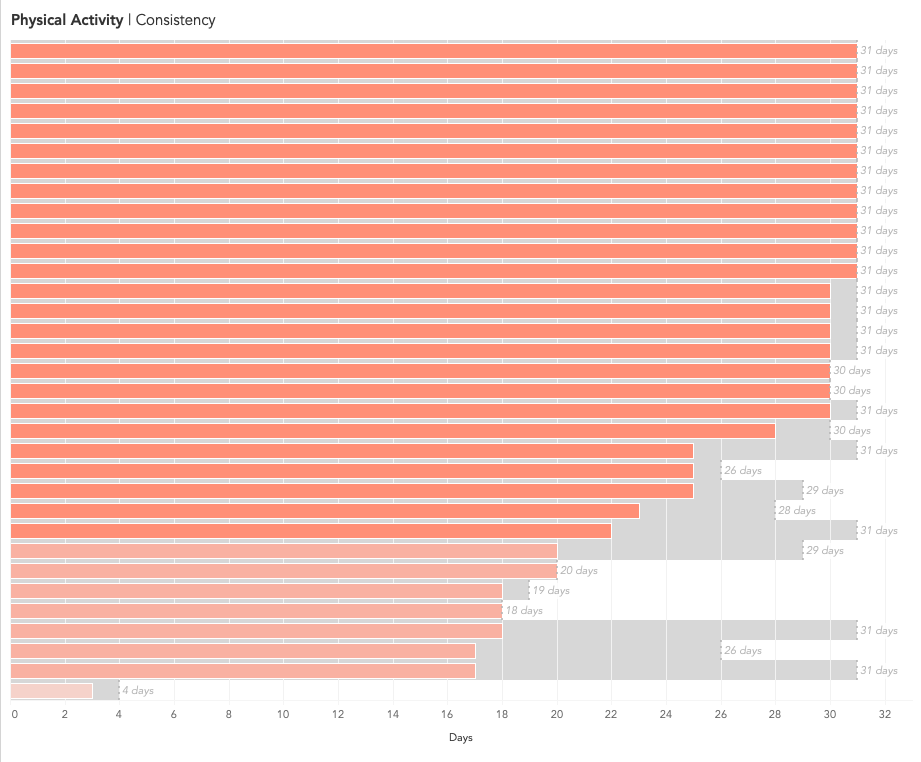

In [44]:
from IPython.display import Image, display
display(Image(filename='../images/engagement_activity_consistency.png', embed=True))

**Consistency** was also **high** with **85%** (28 out of 33) tracking activity **at least 75% of the time** of their active window of usage. 

By looking at **consistency** along with the **usage** numbers, we can get a more refined picture of how users *engage* with this device. Low consistency levels possibly point to issues where the user has experienced the product but still finds it difficult to use, not helpful, or even uncomfortable. Within this group, the remaining **15%** (5 out of 33) of users had a **moderate** level (between 50-75%) of consistency with no user falling into the **low** category (less than 50% of the time). 

This suggests that overall for most users **engagement was good** when it comes to tracking physical activity. 

![engagement_activity_consistency](../../images/engagement_activity_consistency.png)

Next, we'll move on to analyzing engagement with sleep tracking data.

### **Engagement** | Sleep Tracking

In [23]:
%%bigquery
WITH sleep_record_count AS (
    SELECT Id,
           SUM(TotalSleepRecords) AS RecordCount
     FROM `gac-bellabeat.activity.sleep`
    GROUP BY 1
),
active_window AS (
    SELECT Id,
           MIN(SleepDay) AS FirstRecord,
           MAX(SleepDay) AS LastRecord,
           DATE_DIFF(MAX(SleepDay), MIN(SleepDay), DAY) + 1 AS WindowDays, -- add 1 to include usage on final day
     FROM `gac-bellabeat.activity.sleep`
    GROUP BY 1
)
SELECT aw.Id,
       aw.FirstRecord,
       aw.LastRecord,
       aw.ActiveWindowDays,
       src.RecordCount,
       CASE 
        WHEN src.RecordCount >= 21 THEN 'High' 
        WHEN src.RecordCount >= 14 THEN 'Moderate'
        ELSE 'Low'
       END AS UsageLevel,
       ROUND((CASE WHEN src.RecordCount > aw.WindowDays THEN 1 ELSE src.RecordCount / aw.WindowDays END)*100, 0) AS Consistency,
       CASE 
            WHEN ROUND((CASE WHEN src.RecordCount > aw.WindowDays THEN 1 ELSE src.RecordCount / aw.WindowDays END)*100, 0)  >= 75 THEN 'High'
            WHEN ROUND((CASE WHEN src.RecordCount > aw.WindowDays THEN 1 ELSE src.RecordCount / aw.WindowDays END)*100, 0)  >= 50 THEN 'Moderate'
            ELSE 'Low'
       END AS ConsistencyLevel
 FROM active_window aw
 JOIN sleep_record_count src
   ON aw.Id = src.Id
ORDER BY 5 DESC, 6, 7 DESC, 8, 4 DESC, 2, 3;

Executing query with job ID: 58adb344-58b0-404d-94ec-74e994d728e4
Query executing: 0.69s


ERROR:
 400 Name ActiveWindowDays not found inside aw at [18:11]

Location: US
Job ID: 58adb344-58b0-404d-94ec-74e994d728e4



Let's summarize these results.

In [24]:
%%bigquery
WITH sleep_record_count AS (
    SELECT Id,
           SUM(TotalSleepRecords) AS RecordCount
     FROM `gac-bellabeat.activity.sleep`
    GROUP BY 1
),
active_window AS (
    SELECT Id,
           MIN(SleepDay) AS FirstRecord,
           MAX(SleepDay) AS LastRecord,
           DATE_DIFF(MAX(SleepDay), MIN(SleepDay), DAY) + 1 AS ActiveWindowDays, -- add 1 to include usage on final day
     FROM `gac-bellabeat.activity.sleep`
    GROUP BY 1
),
usage_categories AS (
    SELECT aw.Id,
           aw.FirstRecord,
           aw.LastRecord,
           aw.ActiveWindowDays,
           src.RecordCount,
           CASE 
            WHEN src.RecordCount >= 21 THEN 'High' 
            WHEN src.RecordCount >= 14 THEN 'Moderate'
            ELSE 'Low'
           END AS UsageLevel,
           ROUND((CASE WHEN src.RecordCount > aw.ActiveWindowDays THEN 1 ELSE src.RecordCount / aw.ActiveWindowDays END)*100, 0) AS Consistency,
           CASE 
            WHEN ROUND((CASE WHEN src.RecordCount > aw.ActiveWindowDays THEN 1 ELSE src.RecordCount / aw.ActiveWindowDays END)*100, 0)  >= 75 THEN 'High'
            WHEN ROUND((CASE WHEN src.RecordCount > aw.ActiveWindowDays THEN 1 ELSE src.RecordCount / aw.ActiveWindowDays END)*100, 0)  >= 50 THEN 'Moderate'
            ELSE 'Low'
           END AS ConsistencyLevel
     FROM active_window aw
     JOIN sleep_record_count src
       ON aw.Id = src.Id
)
SELECT SUM(CASE WHEN uc.UsageLevel = 'High' THEN 1 ELSE 0 END) AS HighUsage,
       SUM(CASE WHEN uc.UsageLevel = 'Moderate' THEN 1 ELSE 0 END) AS ModerateUsage,
       SUM(CASE WHEN uc.UsageLevel = 'Low' THEN 1 ELSE 0 END) AS LowUsage,  
       SUM(CASE WHEN uc.ConsistencyLevel = 'High' THEN 1 ELSE 0 END) AS HighConsistency,
       SUM(CASE WHEN uc.ConsistencyLevel = 'Moderate' THEN 1 ELSE 0 END) AS ModerateConsistency,
       SUM(CASE WHEN uc.ConsistencyLevel = 'Low' THEN 1 ELSE 0 END) AS LowConsistency,
       COUNT(*) AS TotalUsers
 FROM usage_categories uc;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.19s/rows]


,HighUsage,ModerateUsage,LowUsage,HighConsistency,ModerateConsistency,LowConsistency,TotalUsers
0,13,2,9,16,1,7,24


With sleep tracking we have a slightly different picture. Only **80% of of the group** (24 out of 33 users) took advantage of this functionality and logged their sleep data. This suggests that users in this group were possibly uninterested in monitoring their sleep, unaware of this functionality, or simply unable to activate it.

Additionally, even among those who contributed sleep data, only **54%** (13 out of 24 users) had a **high level of usage** ( at least 3 weeks out of the 1-month period). 

![user_engagement_sleep](../../images/user_engagement_sleep.png)

To measure **consistency** in the sleep data, we looked at the number of sleep logs (`RecordCount`) recorded given the number of days of the active usage window. 

**29% of users** (7 out of 24) had **low consistency levels** indicating they recorded sleep logs **less than 50% of the time**.

Both the low usage and consistency levels may point to issues related to usefulness, understanding of the data, or possibly even discomfort in wearing the device at night.   

*Note that `RecordCount` includes naps taken that are greater than 60 minutes. This explains why in some cases the `RecordCount` exceeds the number of days within the active usage window.*  

![engagement_sleep_consistency](../../images/engagement_sleep_consistency.png)

In the following section, we'll look at user engagement with weight tracking data.

### **Engagement** | Weight Tracking

In [25]:
%%bigquery
SELECT Id,
       MIN(Date) AS FirstRecord,
       MAX(Date) AS LastRecord,
       DATE_DIFF(MAX(Date), MIN(Date), DAY) + 1 AS WindowDays, -- add 1 to include usage on final day
       COUNT(LogId) AS RecordCount,
       SUM(CASE WHEN IsManualReport IS True THEN 1 ELSE 0 END) AS ManualReportCount,
       SUM(CASE WHEN IsManualReport IS False THEN 1 ELSE 0 END) AS AutoReportCount,
       CASE 
        WHEN COUNT(LogId) >= 21 THEN 'High'
        WHEN COUNT(LogId) >= 14 THEN 'Moderate'
        ELSE 'Low'
       END AS UsageLevel,
       ROUND(COUNT(LogId) / (DATE_DIFF(MAX(Date), MIN(Date), DAY) + 1) * 100, 0) AS Consistency,
           CASE 
            WHEN ROUND(COUNT(LogId) / (DATE_DIFF(MAX(Date), MIN(Date), DAY) + 1) * 100, 0) >= 75 THEN 'High'
            WHEN ROUND(COUNT(LogId) / (DATE_DIFF(MAX(Date), MIN(Date), DAY) + 1) * 100, 0) >= 50 THEN 'Moderate'
            ELSE 'Low'
           END AS ConsistencyLevel
 FROM `gac-bellabeat.activity.weight`
GROUP BY Id
ORDER BY 4 DESC, 5 DESC, 9 DESC, 6 DESC, 7 DESC;

Downloading: 100%|██████████| 8/8 [00:01<00:00,  4.52rows/s]


,Id,FirstRecord,LastRecord,WindowDays,RecordCount,ManualReportCount,AutoReportCount,UsageLevel,Consistency,ConsistencyLevel
0,6962181067,2016-04-12 23:59:59+00:00,2016-05-12 23:59:59+00:00,31,30,30,0,High,97.0,High
1,8877689391,2016-04-12 06:47:11+00:00,2016-05-12 06:42:53+00:00,30,24,0,24,High,80.0,High
2,4558609924,2016-04-18 23:59:59+00:00,2016-05-09 23:59:59+00:00,22,5,5,0,Low,23.0,Low
3,2873212765,2016-04-21 23:59:59+00:00,2016-05-12 23:59:59+00:00,22,2,2,0,Low,9.0,Low
4,4319703577,2016-04-17 23:59:59+00:00,2016-05-04 23:59:59+00:00,18,2,2,0,Low,11.0,Low
5,1503960366,2016-05-02 23:59:59+00:00,2016-05-03 23:59:59+00:00,2,2,2,0,Low,100.0,High
6,5577150313,2016-04-17 09:17:55+00:00,2016-04-17 09:17:55+00:00,1,1,0,1,Low,100.0,High
7,1927972279,2016-04-13 01:08:52+00:00,2016-04-13 01:08:52+00:00,1,1,0,1,Low,100.0,High


Let's summarize the results in a table.

In [26]:
%%bigquery
WITH usage_categories AS ( 
    SELECT Id,
           MIN(Date) AS FirstRecord,
           MAX(Date) AS LastRecord,
           DATE_DIFF(MAX(Date), MIN(Date), DAY) + 1 AS WindowDays, -- add 1 to include usage on final day
           COUNT(LogId) AS RecordCount,
           SUM(CASE WHEN IsManualReport IS True THEN 1 ELSE 0 END) AS ManualReportCount,
           SUM(CASE WHEN IsManualReport IS False THEN 1 ELSE 0 END) AS AutoReportCount,
           CASE 
            WHEN COUNT(LogId) >= 21 THEN 'High'
            WHEN COUNT(LogId) >= 14 THEN 'Moderate'
            ELSE 'Low'
           END AS UsageLevel,
           ROUND(COUNT(LogId) / (DATE_DIFF(MAX(Date), MIN(Date), DAY) + 1) * 100, 0) AS Consistency,
           CASE 
            WHEN ROUND(COUNT(LogId) / (DATE_DIFF(MAX(Date), MIN(Date), DAY) + 1) * 100, 0) >= 75 THEN 'High'
            WHEN ROUND(COUNT(LogId) / (DATE_DIFF(MAX(Date), MIN(Date), DAY) + 1) * 100, 0) >= 50 THEN 'Moderate'
            ELSE 'Low'
           END AS ConsistencyLevel
    FROM `gac-bellabeat.activity.weight`
    GROUP BY 1
) 
SELECT SUM(CASE WHEN uc.UsageLevel = 'High' THEN 1 ELSE 0 END) AS HighUsage,
       SUM(CASE WHEN uc.UsageLevel = 'Moderate' THEN 1 ELSE 0 END) AS ModerateUsage,
       SUM(CASE WHEN uc.UsageLevel = 'Low' THEN 1 ELSE 0 END) AS LowUsage, 
       SUM(CASE WHEN ManualReportCount > 0 THEN 1 ELSE 0 END) AS ManualUserCount,
       SUM(CASE WHEN AutoReportCount >0 THEN 1 ELSE 0 END) AS AutoUserCount,
       SUM(CASE WHEN uc.ConsistencyLevel = 'High' THEN 1 ELSE 0 END) AS HighConsistency,
       SUM(CASE WHEN uc.ConsistencyLevel = 'Moderate' THEN 1 ELSE 0 END) AS ModerateConsistency,
       SUM(CASE WHEN uc.ConsistencyLevel = 'Low' THEN 1 ELSE 0 END) AS LowConsistency, 
       COUNT(*) AS TotalUsers
FROM usage_categories uc;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


,HighUsage,ModerateUsage,LowUsage,ManualUserCount,AutoUserCount,HighConsistency,ModerateConsistency,LowConsistency,TotalUsers
0,2,0,6,5,3,5,0,3,8


Compared to activity and sleep tracking, **only a small number** (8 out of 33 users) made use of the weight tracking functionality. This suggests that users may not be interested in monitoring weight, unaware of this capability, or possibly find that the available input methods are troublesome. 

![user_engagement_weight_usage](../../images/user_engagement_weight_usage.png)

Weight logs must be input manually by the user or separately synced with a digital scale (e.g. Fitbit Aria, Withings, etc.) that has been linked to a Fitbit account. **Only 3 out of 8 the users** logged weight data via automated syncing. 

**Of the the 2 users** classified with a **high level** of usage, **one** input data **manually**, while **the other** used the **automated** method.

Among **users of both manual or auto-input methods**, we also see a **low usage level** suggesting that regardless of input method users did not feel the need to continue using this functionality. This points possibly to the lack of a perceived benefit from weight tracking.

![user_engagement_weight_consistency](../../images/user_engagement_weight_consistency.png)

Additionally, from processing our weight data earlier, we noticed that the body fat percentage column had null values for 65 out of 67 rows. Upon closer inspection, we can see that the **only two entries for body fat percentage were manually input** and not via an automated approach like syncing a digital scale with body fat measurement capabilities. This further suggests less interest, ability, or understanding of metrics related to weight management.

In [27]:
%%bigquery
SELECT Id,
       IsManualReport,
       Fat
  FROM `gac-bellabeat.activity.weight`
 WHERE Fat IS NOT NULL;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.33rows/s]


,Id,IsManualReport,Fat
0,4319703577,True,25
1,1503960366,True,22


## **User Habits**

In this section, we'll get a clearer understanding of this group's activity and sleep habits by looking at *when* users do different *intensity* activities.  

### **Habits** | Daily Activity Level

#### Overall Levels

Let's first look at the overall activity level of users over the course of the week. While the Fitbit device provides readings of daily activity in both *steps* and *calories*, we'll use the daily total number of steps (`TotalSteps`) for this analysis.

**Steps** are calculated by taking the *distance moved* divided by the *stride length* (this is determined by using height measurements provided by the user). 

`Calories`, on the other hand, are a less intuitive and less direct method of measuring activity since the metric incorporates additional variables: *heart rate* (a faster rate will burn more calories) and the *Basal Metabolic Rate (BMR)*, which estimates how many calories are burned at rest (estimated by the Fitbit device using user-provided height, gender, weight, and age).

In [28]:
%%bigquery
WITH indiv_avg AS ( 
  SELECT Id,
         FORMAT_DATE('%a', ActivityDate) AS DayOfWeek,
         FORMAT_DATE('%w', ActivityDate) AS DayOfWeekOrder,
         AVG(TotalSteps) AS IndivAvgSteps
    FROM `gac-bellabeat.activity.daily`
   GROUP BY 1, 2, 3
),
group_avg AS (
    SELECT DayOfWeek,
           DayOfWeekOrder,
           ROUND(AVG(IndivAvgSteps), 0) AS AvgSteps
      FROM indiv_avg
     GROUP BY 1, 2
)
SELECT DayOfWeek,
       AvgSteps,
       ROUND(AVG(AvgSteps) OVER(), 0) AS WeeklyAvgSteps,
       ROUND(AvgSteps - AVG(AvgSteps) OVER(), 1) AS Delta,
       ROUND(((AvgSteps - AVG(AvgSteps) OVER()) / AVG(AvgSteps) OVER())*100, 1) AS PctDiff
 FROM group_avg
GROUP BY 1, 2, DayOfWeekOrder
ORDER BY DayOfWeekOrder;

Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.65rows/s]


,DayOfWeek,AvgSteps,WeeklyAvgSteps,Delta,PctDiff
0,Sun,6950.0,7582.0,-631.9,-8.3
1,Mon,7785.0,7582.0,203.1,2.7
2,Tue,7993.0,7582.0,411.1,5.4
3,Wed,7512.0,7582.0,-69.9,-0.9
4,Thu,7202.0,7582.0,-379.9,-5.0
5,Fri,7328.0,7582.0,-253.9,-3.3
6,Sat,8303.0,7582.0,721.1,9.5


![habits_daily_overall_steps](../../images/habits_daily_overall_steps.png)

With this group we can see that generally **users are most active on Saturday** with **almost a 10% increase in activity** over the weekly average. The next most active days occur near the start of the the week, **Tuesday** followed by **Monday**. 

**Sunday** had the lowest level of overall activity **decreasing more than 8%** from the weekly average.

#### **Exercise** | Very Active and Fairly Active Intensity Levels


We can also get a more refined understanding of the types of activity users engage in by looking at *intensity level* data.

Fitbit devices record intensity (at the minute level) and group them into four categories:

- **Very Active** (>6.0 METs**): activities such as jogging, running, cycling at over 10mph, fast swimming
- **Fairly Active** (3.0-6.0 METs): activities such as baseball, golf, brisk walking, weight lifting, gardening, yoga
- **Lightly Active** (1.5-2.9 METs): activities such as walking at a slow pace, washing dishes, playing the piano, fishing
- **Sedentary** (<1.5 METs): activities sitting quietly, reading a book, writing

** *[Metabolic Equivalent of Task (MET)](https://en.wikipedia.org/wiki/Metabolic_equivalent_of_task): a MET of 1 is approximately equivalent to the level of exertion from sitting still.* 

Practically speaking, we can think of the categories of `VeryActiveMinutes` and `FairlyActiveMinutes` as the *intensity* and *duration* of doing some type of activity akin to *exercise*. For simplicity's sake, throughout this analysis we'll refer to any activity that is done at moderate- or high-intensity as "exercise". 

For the remaining lower intensity levels (`LightlyActive` and `Sedentary`), for convenience's sake, we'll refer to them as "general movements", or those movements done for everyday tasks.

In [29]:
%%bigquery
WITH indiv_avg_intensity AS (
    SELECT Id,
           FORMAT_DATE('%a', ActivityDate) AS DayOfWeek,
           FORMAT_DATE('%w', ActivityDate) AS DayOfWeekOrder,
           AVG(VeryActiveMinutes) AS IndivAvgVeryActiveMinutes,
           AVG(FairlyActiveMinutes) AS IndivAvgFairlyActiveMinutes 
    FROM `gac-bellabeat.activity.daily`
    GROUP BY 1, 2, 3
),
group_avg_intensity AS (
    SELECT DayOfWeek,
           DayOfWeekOrder,
           ROUND(AVG(IndivAvgVeryActiveMinutes), 1) AS AvgVeryActiveMinutes,
           ROUND(AVG(IndivAvgFairlyActiveMinutes), 1) AS AvgFairlyActiveMinutes,
      FROM indiv_avg_intensity
     GROUP BY 1, DayOfWeekOrder
)
SELECT  DayOfWeek,
        AvgVeryActiveMinutes,
        ROUND(AVG(AvgVeryActiveMinutes) OVER(), 1) AS WeeklyAvgVeryActiveMinutes,
        ROUND(AvgVeryActiveMinutes - AVG(AvgVeryActiveMinutes) OVER(), 1) AS VeryActiveDelta,
        ROUND((AvgVeryActiveMinutes - AVG(AvgVeryActiveMinutes) OVER()) / AVG(AvgVeryActiveMinutes) OVER()*100, 1) 
            AS VeryActivePctDiff,
        AvgFairlyActiveMinutes,
        ROUND(AVG(AvgFairlyActiveMinutes) OVER(), 1) AS WeeklyAvgFairlyActiveMinutes,
        ROUND(AvgFairlyActiveMinutes - AVG(AvgFairlyActiveMinutes) OVER(), 1) AS FairlyActiveDelta,
        ROUND((AvgFairlyActiveMinutes - AVG(AvgFairlyActiveMinutes) OVER()) / AVG(AvgFairlyActiveMinutes) OVER()*100, 1) 
            AS FairlyActivePctDiff,
  FROM group_avg_intensity
 GROUP BY 1, 2, 6, DayOfWeekOrder   
 ORDER BY DayOfWeekOrder;

Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.80rows/s]


,DayOfWeek,AvgVeryActiveMinutes,WeeklyAvgVeryActiveMinutes,VeryActiveDelta,VeryActivePctDiff,AvgFairlyActiveMinutes,WeeklyAvgFairlyActiveMinutes,FairlyActiveDelta,FairlyActivePctDiff
0,Sun,19.7,20.7,-1.0,-4.7,14.1,13.5,0.6,4.6
1,Mon,22.8,20.7,2.1,10.3,14.2,13.5,0.7,5.3
2,Tue,21.9,20.7,1.2,5.9,13.5,13.5,0.0,0.1
3,Wed,20.1,20.7,-0.6,-2.8,12.8,13.5,-0.7,-5.1
4,Thu,18.7,20.7,-2.0,-9.5,12.1,13.5,-1.4,-10.3
5,Fri,19.3,20.7,-1.4,-6.6,11.9,13.5,-1.6,-11.8
6,Sat,22.2,20.7,1.5,7.4,15.8,13.5,2.3,17.2


As neither `VeryActiveMinutes` nor `FairlyActiveMinutes` exceeds 25 minutes on average, we can look at them as *reflecting the mix of exercise-level activity* throughout the week.  

Most ***exercise-level activity*** (both high- and moderate-intensity activity) peak on **Saturday** and **Monday**. Beyond these two days, we see differences start to emerge depending on intensity. For **high-intensity activity** (e.g., jogging, cycling at over 10mph, fast swimming), **Tuesday** marks the next highest level (5.6% higher than the weekly average). On the other hand, for **moderate-intensity activity** (e.g., yoga, golf, brisk walking, gardening), the next highest level is on **Sunday** (4.6% higher than the weekly average).   

![habits_daily_exercise_intensity](../../images/habits_daily_exercise_intensity.png)

#### **General Movements** | Lightly Active and Sedentary Intensity Levels


Now let's look more closely at weekly intensity levels for **general movements** (`LightlyActive` and `Sedentary`). 

In [30]:
%%bigquery
WITH indiv_avg_intensity AS (
    SELECT Id,
           FORMAT_DATE('%a', ActivityDate) AS DayOfWeek,
           FORMAT_DATE('%w', ActivityDate) AS DayOfWeekOrder,
           AVG(LightlyActiveMinutes) AS IndivAvgLightlyActiveMinutes,
           AVG(SedentaryMinutes) AS IndivAvgSedentaryMinutes    
    FROM `gac-bellabeat.activity.daily`
    GROUP BY 1, 2, 3
),
group_avg_intensity AS (
    SELECT DayOfWeek,
           DayOfWeekOrder,
           ROUND(AVG(IndivAvgLightlyActiveMinutes), 1) AS AvgLightlyActiveMinutes,
           ROUND(AVG(IndivAvgSedentaryMinutes), 1) AS AvgSedentaryMinutes
      FROM indiv_avg_intensity
     GROUP BY 1, DayOfWeekOrder
)
SELECT  DayOfWeek,
        AvgLightlyActiveMinutes,
        ROUND(AVG(AvgLightlyActiveMinutes) OVER(), 1) AS WeeklyAvgLightlyActiveMinutes,
        ROUND(AvgLightlyActiveMinutes - AVG(AvgLightlyActiveMinutes) OVER(), 1) AS LightlyActiveDelta,
        ROUND((AvgLightlyActiveMinutes - AVG(AvgLightlyActiveMinutes) OVER()) / AVG(AvgLightlyActiveMinutes) OVER() * 100, 1)
            AS LightlyActivePctDiff, 
        AvgSedentaryMinutes,
        ROUND(AVG(AvgSedentaryMinutes) OVER(), 1) AS WeeklyAvgSedentaryMinutes,
        ROUND(AvgSedentaryMinutes - AVG(AvgSedentaryMinutes) OVER(), 1) AS SedentaryDelta,
        ROUND((AvgSedentaryMinutes - AVG(AvgSedentaryMinutes) OVER()) / AVG(AvgSedentaryMinutes) OVER() * 100, 1)
            AS SedentaryPctDiff
  FROM group_avg_intensity
 GROUP BY 1, 2, 6, DayOfWeekOrder   
 ORDER BY DayOfWeekOrder;

Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.77rows/s]


,DayOfWeek,AvgLightlyActiveMinutes,WeeklyAvgLightlyActiveMinutes,LightlyActiveDelta,LightlyActivePctDiff,AvgSedentaryMinutes,WeeklyAvgSedentaryMinutes,SedentaryDelta,SedentaryPctDiff
0,Sun,175.8,193.2,-17.4,-9.0,991.9,997.4,-5.5,-0.5
1,Mon,194.7,193.2,1.5,0.8,1028.9,997.4,31.5,3.2
2,Tue,198.7,193.2,5.5,2.8,1018.6,997.4,21.2,2.1
3,Wed,191.0,193.2,-2.2,-1.1,1000.4,997.4,3.0,0.3
4,Thu,181.9,193.2,-11.3,-5.9,979.8,997.4,-17.6,-1.8
5,Fri,201.5,193.2,8.3,4.3,996.9,997.4,-0.5,-0.0
6,Sat,208.9,193.2,15.7,8.1,965.1,997.4,-32.3,-3.2


With **light-intensity activity**, which are more representative of general movements, we see also **Saturday** as a peak for **light-intensity (`LightlyActive`) activity** (8.1% higher than the weekly average). However, the next highest level of light-intensity activity (4.3% higher than the weekly average) occurs on **Friday**. Perhaps the beginning of the weekend sees more people moving about in general even if it's not at the intensity level of exercise.

`Sedentary` levels vary less throughout the week than all the other activity, with **deviation from the average not exceeding 3.2% in either direction**. However, while **Saturday**, **Monday***, and **Tuesday** all have elevated high-intensity levels, they differ with sedentary levels. **Saturday** has the **lowest** sedentary level while both **Monday** and **Tuesday** have above-average sedentary levels. Perhaps this is a reflection the more sedentary work habits of weekdays.  

![habits_daily_general_movements](../../images/habits_daily_general_movements.png)

### **Habits** | Hourly Activity Level

Now let's drill down further and examine hourly activity levels to understand the average day.

In [31]:
%%bigquery
WITH indiv_avg_hourly AS (
    SELECT Id,
           EXTRACT(hour FROM ActivityHour) AS HourOfDay,
           ROUND(AVG(StepTotal), 0) AS IndivAvgSteps
     FROM `gac-bellabeat.activity.hourly`
    GROUP BY 1, 2
)
SELECT HourOfDay,
       ROUND(AVG(IndivAvgSteps), 0) AS AvgSteps
 FROM indiv_avg_hourly
GROUP BY 1
ORDER BY 1

Downloading: 100%|██████████| 24/24 [00:01<00:00, 17.44rows/s]


,HourOfDay,AvgSteps
0,0,40.0
1,1,22.0
2,2,16.0
3,3,7.0
4,4,12.0
5,5,41.0
6,6,172.0
7,7,318.0
8,8,453.0
9,9,433.0


![habits_hourly_steps_intensity](../../images/habits_hourly_steps_intensity.png)

Activity appears to **peak twice a day**, first during **mid-day** (12-3pm), and then again at **even higher** levels in the **early evening** (5-8pm). 

### **Habits** | Daily and Hourly Activity Levels

To get an even more nuanced picture, we can combine both *daily* and *hourly* activity to understand the pattern of activity for an average week. 

In [32]:
%%bigquery
WITH indiv_avg_hourly AS (
    SELECT Id,
           FORMAT_DATE('%a', ActivityHour) AS DayOfWeek,
           FORMAT_DATE('%w', ActivityHour) AS DayOfWeekOrder,
           EXTRACT(hour FROM ActivityHour) AS HourOfDay,
           ROUND(AVG(StepTotal), 0) AS IndivAvgSteps
     FROM `gac-bellabeat.activity.hourly`
    GROUP BY 1, 2, 3, 4
)
SELECT DayOfWeek,
       HourOfDay,
       ROUND(AVG(IndivAvgSteps), 0) AS AvgSteps
 FROM indiv_avg_hourly
GROUP BY DayOfWeek, DayOfWeekOrder, HourOfDay
ORDER BY DayOfWeekOrder, HourOfDay

Downloading: 100%|██████████| 168/168 [00:01<00:00, 125.15rows/s]


,DayOfWeek,HourOfDay,AvgSteps
0,Sun,0,79.0
1,Sun,1,50.0
2,Sun,2,47.0
3,Sun,3,5.0
4,Sun,4,6.0
...,...,...,...
163,Sat,19,571.0
164,Sat,20,406.0
165,Sat,21,342.0
166,Sat,22,307.0


![habits_daily_hourly_intensity](../../images/habits_daily_hourly_intensity.png)

Looking at how hourly activity varies throughout the week, noticeably **Saturday has the most activity** (663-793 steps) which occurs during the midday hours (11-3pm). This is followed by **heightened activity** (616-718 steps) in the **early evening** (5-8pm) on **all weekdays except Thursday**, and also around **noon** on **Sunday** and **Tuesday** (12-1pm).

### **Habits** | Sleep

In our last section looking at user habits, we'll examine daily sleep patterns.

#### **Sleep** | Hours Asleep

In [33]:
%%bigquery
WITH indiv_avg_sleep AS (
    SELECT Id,
           FORMAT_DATE('%a', SleepDay) AS DayOfWeek,
           FORMAT_DATE('%w', SleepDay) AS DayOfWeekOrder,
           ROUND(AVG(TotalMinutesAsleep), 0) AS IndivAvgSleepMinutes,
           ROUND(AVG(TotalMinutesAsleep)/60, 2) AS IndivAvgSleepHour
    FROM `gac-bellabeat.activity.sleep`
    GROUP BY 1, 2, 3 
),
group_avg_sleep AS (
    SELECT DayOfWeek,
           DayOfWeekOrder,
           ROUND(AVG(IndivAvgSleepMinutes), 0) AS AvgSleepMinutes,
           ROUND(AVG(IndivAvgSleepHour), 2) AS AvgSleepHour
      FROM indiv_avg_sleep
     GROUP BY 1, 2
)
SELECT DayOfWeek,
       AvgSleepMinutes,
       ROUND(AVG(AvgSleepMinutes) OVER(), 0) AS WeeklyAvgSleepMinutes,
       ROUND(AvgSleepMinutes - (AVG(AvgSleepMinutes) OVER()), 0) AS SleepMinutesDelta,
       ROUND((AvgSleepMinutes - (AVG(AvgSleepMinutes) OVER())) / AVG(AvgSleepMinutes) OVER() *100, 1) AS SleepMinutesPctDiff,
       AvgSleepHour,
       ROUND(AVG(AvgSleepHour) OVER(), 2) AS WeeklyAvgSleepHour,
       ROUND(AvgSleepHour - (AVG(AvgSleepHour) OVER()), 2) AS SleepHourDelta,
       ROUND((AvgSleepHour - (AVG(AvgSleepHour) OVER())) / AVG(AvgSleepHour) OVER() *100, 1) AS SleepHourPctDiff,
 FROM group_avg_sleep 
GROUP BY 1, 2, 6, DayOfWeekOrder
ORDER BY DayOfWeekOrder

Downloading: 100%|██████████| 7/7 [00:01<00:00,  5.36rows/s]


,DayOfWeek,AvgSleepMinutes,WeeklyAvgSleepMinutes,SleepMinutesDelta,SleepMinutesPctDiff,AvgSleepHour,WeeklyAvgSleepHour,SleepHourDelta,SleepHourPctDiff
0,Sun,425.0,405.0,20.0,4.9,7.08,6.75,0.33,4.8
1,Mon,436.0,405.0,31.0,7.6,7.26,6.75,0.51,7.5
2,Tue,404.0,405.0,-1.0,-0.3,6.73,6.75,-0.02,-0.3
3,Wed,429.0,405.0,24.0,5.9,7.14,6.75,0.39,5.7
4,Thu,373.0,405.0,-32.0,-8.0,6.22,6.75,-0.53,-7.9
5,Fri,394.0,405.0,-11.0,-2.8,6.57,6.75,-0.18,-2.7
6,Sat,376.0,405.0,-29.0,-7.2,6.27,6.75,-0.48,-7.2


Users receive the **most amount of sleep on Monday**, about **30 minutes (or 8%) more than the weekly average of 405 minutes (or 6.75 hours)**. This is followed by **Sunday** and **Wednesday** when users get **20-25 minutes (or 7%) more sleep than the weekly average**.  

On average users get the **least amount of sleep on Thursday**, only about **6.22 hours**, which is **32 minutes less than the weekly average**.

![sleep_overall](../../images/sleep_overall.png)

#### **Sleep**  | Time to Fall Asleep

In [34]:
%%bigquery
WITH indiv_avg_sleep AS (
    SELECT Id,
           FORMAT_DATE('%a', SleepDay) AS DayOfWeek,
           FORMAT_DATE('%w', SleepDay) AS DayOfWeekOrder,
           ROUND(AVG(TotalMinutesAsleep), 0) AS IndivAvgSleepMinutes,
    FROM `gac-bellabeat.activity.sleep`
    GROUP BY 1, 2, 3
), 
group_avg_sleep AS (
    SELECT DayOfWeek,
           DayOfWeekOrder,
           ROUND(AVG(IndivAvgSleepMinutes), 0) AS AvgSleepMinutes,
     FROM indiv_avg_sleep 
    GROUP BY 1, 2
),
indiv_avg_bed AS (
    SELECT Id,
           FORMAT_DATE('%a', SleepDay) AS DayOfWeek,
           FORMAT_DATE('%w', SleepDay) AS DayOfWeekOrder,
           ROUND(AVG(TotalTimeInBed), 0) AS AvgTimeInBedMinutes,
     FROM `gac-bellabeat.activity.sleep`
    GROUP BY 1, 2, 3
),
group_avg_bed AS (
    SELECT DayOfWeek,
           DayOfWeekOrder,
           ROUND(AVG(AvgTimeInBedMinutes), 0) AS AvgInBedMinutes, 
     FROM indiv_avg_bed
    GROUP BY 1, 2
)
SELECT gas.DayOfWeek,
       gab.AvgInBedMinutes,
       gas.AvgSleepMinutes,
       gab.AvgInBedMinutes - gas.AvgSleepMinutes AS FallAsleepMinutes,
       ROUND(AVG(gab.AvgInBedMinutes - gas.AvgSleepMinutes) OVER(), 0) AS WeeklyAvgFallAsleepMinutes,
       ROUND((gab.AvgInBedMinutes - gas.AvgSleepMinutes) - AVG(gab.AvgInBedMinutes - gas.AvgSleepMinutes) OVER(), 0) 
        AS AvgMinutesDelta,
       ROUND((gab.AvgInBedMinutes - gas.AvgSleepMinutes) - AVG(gab.AvgInBedMinutes - gas.AvgSleepMinutes) OVER(), 0)/
            ROUND(AVG(gab.AvgInBedMinutes - gas.AvgSleepMinutes) OVER(), 0)*100 AS AvgMinutesPctDiff
 FROM group_avg_sleep gas
 JOIN group_avg_bed gab
   ON gas.DayOfWeek = gab.DayOfWeek
ORDER BY gas.DayOfWeekOrder;

Downloading: 100%|██████████| 7/7 [00:01<00:00,  5.26rows/s]


,DayOfWeek,AvgInBedMinutes,AvgSleepMinutes,FallAsleepMinutes,WeeklyAvgFallAsleepMinutes,AvgMinutesDelta,AvgMinutesPctDiff
0,Sun,480.0,425.0,55.0,40.0,15.0,37.5
1,Mon,478.0,436.0,42.0,40.0,2.0,5.0
2,Tue,440.0,404.0,36.0,40.0,-4.0,-10.0
3,Wed,464.0,429.0,35.0,40.0,-5.0,-12.5
4,Thu,404.0,373.0,31.0,40.0,-9.0,-22.5
5,Fri,438.0,394.0,44.0,40.0,4.0,10.0
6,Sat,416.0,376.0,40.0,40.0,-0.0,-0.0


Once in bed, users took **on average 40 minutes to fall asleep**. During the mid-part of the week, we see even shorter times with **Thursday** leading the way—users on average dozed off **23% more quickly**, or in other words **in roughly 30 minutes**. 

On the other end of the spectrum, **Sundays** on average **took the longest** for users to fall asleep needing **about 55 minutes** (or 38% longer than the weekly average). 

![sleep_time_fall_asleep](../../images/sleep_time_fall_asleep.png)

## **User Profile**

Although no demographic information accompanied the dataset for this group of users, in this section we'll try to build a user profile based on our earlier analysis and statistics for the average American. 

### **Profile** | Activity Levels

In [35]:
%%bigquery
WITH indiv_avg AS ( 
  SELECT Id,
         AVG(TotalSteps) AS IndivAvgSteps
    FROM `gac-bellabeat.activity.daily`
   GROUP BY 1
),
group_avg AS (
    SELECT ROUND(AVG(IndivAvgSteps), 0) AS GroupAvgSteps
      FROM indiv_avg
)
SELECT GroupAvgSteps,
       AVG(5117) OVER() AS AmericanAvgSteps,
       GroupAvgSteps - 5117 AS Delta,
       ROUND((GroupAvgSteps - 5117) / 5117 * 100, 1) AS PctDiff
 FROM group_avg

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.39s/rows]


,GroupAvgSteps,AmericanAvgSteps,Delta,PctDiff
0,7519.0,5117.0,2402.0,46.9


Based on our analysis, this group of users on average takes **7,519 steps** a day which makes them about **50% more active than [the average American, who takes about 5,000 steps (~2.5 miles) a day](https://journals.lww.com/acsm-msse/Fulltext/2010/10000/Pedometer_Measured_Physical_Activity_and_Health.4.aspx)**.[<sup>1</sup>](#fn1)

![profile_activity_overall](../../images/profile_activity_overall.png)

In [36]:
%%bigquery
WITH indiv_avg_intensity AS (
    SELECT Id,
           FORMAT_DATE('%a', ActivityDate) AS DayOfWeek,
           FORMAT_DATE('%w', ActivityDate) AS DayOfWeekOrder,
           AVG(VeryActiveMinutes) AS IndivAvgVeryActiveMinutes,
           AVG(FairlyActiveMinutes) AS IndivAvgFairlyActiveMinutes, 
           AVG(VeryActiveMinutes)+AVG(FairlyActiveMinutes) AS IndivAvgExerciseMinutes
    FROM `gac-bellabeat.activity.daily`
    GROUP BY 1, 2, 3
),
group_avg_intensity AS (
    SELECT DayOfWeek,
           DayOfWeekOrder,
           AVG(IndivAvgVeryActiveMinutes) AS AvgVeryActiveMinutes,
           AVG(IndivAvgFairlyActiveMinutes) AS AvgFairlyActiveMinutes,
           AVG(IndivAvgVeryActiveMinutes) + AVG(IndivAvgFairlyActiveMinutes) AS AvgExerciseMinutes
      FROM indiv_avg_intensity
     GROUP BY 1, DayOfWeekOrder
)
SELECT  ROUND(AVG(AvgVeryActiveMinutes), 1) AS DailyAvgVeryActiveMinutes,
        ROUND(AVG(AvgFairlyActiveMinutes), 1) AS DailyAvgFairlyActiveMinutes,
        ROUND(AVG(AvgVeryActiveMinutes) + AVG(AvgFairlyActiveMinutes),1) AS DailyAvgExerciseMinutes,
        22.2 AS USDailyAvgExerciseMinutes,
        ROUND(AVG(AvgVeryActiveMinutes) + AVG(AvgFairlyActiveMinutes),1) - 22.2 AS Delta,
        ROUND(((AVG(AvgVeryActiveMinutes) + AVG(AvgFairlyActiveMinutes)) - 22.2) / 22.2 *100, 1) AS PctDiff
  FROM group_avg_intensity;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


,DailyAvgVeryActiveMinutes,DailyAvgFairlyActiveMinutes,DailyAvgExerciseMinutes,USDailyAvgExerciseMinutes,Delta,PctDiff
0,20.7,13.5,34.2,22.2,12.0,53.9


In addition, this group on average spent **34.2 minutes each day on exercise** (moderate- to high-intensity activity), which is **54% higher than [the average time (22.2 minutes) Americans spend daily on sports, exercise, and recreation](https://www.statista.com/statistics/189535/daily-average-time-spent-on-sports-and-exercise-in-the-us/)**.[<sup>2</sup>](#fn2)

![profile_activity_exercise](../../images/profile_activity_exercise.png)

Taken together, this group of **users** appears to be **much more active overall** and in **moderate-** to **high-intensity activity** than the **average American**. 

### **Profile** | Sleep

In [37]:
%%bigquery
WITH indiv_avg_sleep AS (
    SELECT Id,
           FORMAT_DATE('%a', SleepDay) AS DayOfWeek,
           FORMAT_DATE('%w', SleepDay) AS DayOfWeekOrder,
           ROUND(AVG(TotalMinutesAsleep), 0) AS IndivAvgSleepMinutes,
           ROUND(AVG(TotalMinutesAsleep)/60, 2) AS IndivAvgSleepHour
    FROM `gac-bellabeat.activity.sleep`
    GROUP BY 1, 2, 3 
),
group_avg_sleep AS (
    SELECT DayOfWeek,
           DayOfWeekOrder,
           ROUND(AVG(IndivAvgSleepMinutes), 0) AS AvgSleepMinutes,
           ROUND(AVG(IndivAvgSleepHour), 2) AS AvgSleepHour
      FROM indiv_avg_sleep
     GROUP BY 1, 2
)
SELECT ROUND(AVG(AvgSleepMinutes), 0) AS DailyAvgSleepMinutes,
       ROUND(AVG(AvgSleepHour), 2) AS DailyAvgSleepHour,
       6.80 AS USDailyAvgSleepHour
 FROM group_avg_sleep;


Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


,DailyAvgSleepMinutes,DailyAvgSleepHour,USDailyAvgSleepHour
0,405.0,6.75,6.8


Users in this group **on average slept for 6.75 hours (405 minutes) each night** aligning with **[the amount of sleep gotten by the average American](https://news.gallup.com/poll/166553/less-recommended-amount-sleep.aspx)**.[<sup>3</sup>](#fn3)


![profile_sleep_overall](../../images/profile_sleep_overall.png)

### **Profile** | Weight

In [38]:
%%bigquery
WITH indiv_avg_weight AS (
    SELECT Id,
           ROUND(AVG(WeightPounds), 0) AS IndivAvgWeightPounds,
           ROUND(AVG(WeightKg), 0) AS IndivAvgWeightKg,
           ROUND(AVG(BMI), 0) AS IndivAvgBMI
    FROM `gac-bellabeat.activity.weight`
    GROUP BY 1
)
SELECT Id,
       IndivAvgWeightPounds,
       AVG(IndivAvgWeightPounds) OVER() AS AvgWeightPounds,
       IndivAvgWeightKg,
       AVG(IndivAvgWeightKg) OVER() AS AvgWeightKg,
       IndivAvgBMI,
       CASE 
         WHEN IndivAvgBMI >= 30.0 THEN 'Obese'
         WHEN IndivAvgBMI >= 25.0 THEN 'Overweight'
         WHEN IndivAvgBMI >= 18.5 THEN 'Healthy'
         ELSE 'Underweight'
       END AS CDCAssessment,     
       AVG(IndivAvgBMI) OVER() AS AvgBMI  
 FROM indiv_avg_weight
ORDER BY 2

Downloading: 100%|██████████| 8/8 [00:01<00:00,  4.48rows/s]


,Id,IndivAvgWeightPounds,AvgWeightPounds,IndivAvgWeightKg,AvgWeightKg,IndivAvgBMI,CDCAssessment,AvgBMI
0,1503960366,116.0,171.75,53.0,78.0,23.0,Healthy,28.0
1,2873212765,126.0,171.75,57.0,78.0,22.0,Healthy,28.0
2,6962181067,136.0,171.75,62.0,78.0,24.0,Healthy,28.0
3,4558609924,154.0,171.75,70.0,78.0,27.0,Overweight,28.0
4,4319703577,160.0,171.75,72.0,78.0,27.0,Overweight,28.0
5,8877689391,188.0,171.75,85.0,78.0,25.0,Overweight,28.0
6,5577150313,200.0,171.75,91.0,78.0,28.0,Overweight,28.0
7,1927972279,294.0,171.75,134.0,78.0,48.0,Obese,28.0


In [39]:
%%bigquery
WITH indiv_avg_weight AS (
    SELECT Id,
           ROUND(AVG(WeightPounds), 0) AS IndivAvgWeightPounds,
           ROUND(AVG(WeightKg), 0) AS IndivAvgWeightKg,
           ROUND(AVG(BMI), 0) AS IndivAvgBMI
    FROM `gac-bellabeat.activity.weight`
    GROUP BY 1
),
group_avg_weight AS (
    SELECT Id,
           IndivAvgWeightPounds,
           AVG(IndivAvgWeightPounds) OVER() AS AvgWeightPounds,
           IndivAvgWeightKg,
           AVG(IndivAvgWeightKg) OVER() AS AvgWeightKg,
           IndivAvgBMI,
           CASE 
             WHEN IndivAvgBMI >= 30.0 THEN 'Obese'
             WHEN IndivAvgBMI >= 25.0 THEN 'Overweight'
             WHEN IndivAvgBMI >= 18.5 THEN 'Healthy'
             ELSE 'Underweight'
           END AS CDCLabel,     
           AVG(IndivAvgBMI) OVER() AS AvgBMI  
      FROM indiv_avg_weight
)
SELECT ROUND(SUM(CASE WHEN CDCLabel = 'Obese' THEN 1 ELSE 0 END) / COUNT(Id)*100, 1) AS PctObese,  
       ROUND(SUM(CASE WHEN CDCLabel = 'Overweight' THEN 1 ELSE 0 END) / COUNT(Id)*100, 1) AS PctOverweight,
       ROUND(SUM(CASE WHEN CDCLabel = 'Healthy' THEN 1 ELSE 0 END) / COUNT(Id)*100, 1) AS PctHealthy,
       AvgWeightPounds, 
       AvgBMI,
       25.6 AS USMenBMI,
       25.5 AS USWomenBMI 
  FROM group_avg_weight
 GROUP BY 4, 5, 6, 7

Downloading: 100%|██████████| 1/1 [00:05<00:00,  5.62s/rows]


,PctObese,PctOverweight,PctHealthy,AvgWeightPounds,AvgBMI,USMenBMI,USWomenBMI
0,12.5,50.0,37.5,171.75,28.0,25.6,25.5


Only a small subset of 8 from the larger group of 33 users provided information related to their weight, possibly for any of the reasons outlined in the **Engagement** | Weight section. With the caveat that this subset is small and may not be representative of the the full 33-user sample, nor the broader fitness smart device population, we'll tentatively draw insights from what limited data we have. 

Based on this data, the group is **on the heavier side with an average BMI of 28, which is greater than [the average American BMI regardless of sex, which are 25.6 and 25.5, for men and women, respectively](https://www.cdc.gov/nchs/data/nhanes/databriefs/adultweight.pdf)**.[<sup>4</sup>](#fn4)

![profile_weightbmi](../../images/profile_weightbmi.png)

Using the [assessment guidelines](https://www.cdc.gov/nchs/data/nhanes/databriefs/adultweight.pdf)[<sup>5</sup>](#fn5) outlined by the CDC, **50% of the group** can be classified as **overweight**, **12.5%** as **obese**, and only **37.5%** as falling within the **healthy** range.

Before making any recommendations based on this particular insight, we would suggest obtaining more data to corroborate the findings on weight.

![profile_cdc_assessment](../../images/profile_cdc_assessment.png)

### References

References used in this analysis:

<span id="fn1"> 1. <a href="https://journals.lww.com/acsm-msse/Fulltext/2010/10000/Pedometer_Measured_Physical_Activity_and_Health.4.aspx">https://journals.lww.com/acsm-msse/Fulltext/2010/10000/Pedometer_Measured_Physical_Activity_and_Health.4.aspx</a> </span>

<span id="fn2"> 2. <a href="https://www.statista.com/statistics/189535/daily-average-time-spent-on-sports-and-exercise-in-the-us/">https://www.statista.com/statistics/189535/daily-average-time-spent-on-sports-and-exercise-in-the-us/</a> </span>

<span id="fn3"> 3. <a href="https://news.gallup.com/poll/166553/less-recommended-amount-sleep.aspx"> https://news.gallup.com/poll/166553/less-recommended-amount-sleep.aspx </a> </span>

<span id="fn4"> 4. <a href="https://www.cdc.gov/nchs/data/nhanes/databriefs/adultweight.pdf">https://www.cdc.gov/nchs/data/nhanes/databriefs/adultweight.pdf</a> </span>

<span id="fn5"> 5. <a href="https://www.cdc.gov/nchs/data/nhanes/databriefs/adultweight.pdf">Ibid.</a> </span>

# **SHARE**

In this section, we'll summarize the findings from our analysis and make actionable recommendations for a marketing strategy to grow Bellabeat's user base. 

## Executive Summary

<span id="s1"> </span>

### **Business Task**

The objectives of this analysis were twofold:

1. ***Understand how current consumers use non-Bellabeat smart devices and leverage these insights to find opportunities for growth***

2. ***Make recommendations for a marketing strategy informed by these findings*** **[(Section 7.1)](#s2)**

Analyzing the tracking data for a group of 33 Fitbit users, we first looked at **user engagement** levels (tracking activity, sleep, and weight) and **user habits** for activity and sleep (on a daily and hourly basis). Based on these findings, we then constructed a **user profile** to help develop a marketing strategy for customer acquistion. 

### **User Engagement**

To measure **user engagement** with the device, we focused on two metrics: 
1) **usage**: an absolute measure of how many days users actively tracked their data (activity, sleep, or weight)
2) **consistency**: a relative measure that looked at the regularity users tracked their data within their window of first and last usage

Overall we found that users were **quite engaged with tracking physical activity** with ***all*** users taking advantage of this functionality. **76%** had a **high level of usage** (using the device at least 21 days out of the 1-month period), and **85%** had a **high level of consistency** (regularly using the device at least 75% of the time). 

**Fewer users** (only 80%) **took advantage of tracking their sleep**. And, within this smaller group, only **54%** had a **high level of usage**. In fact, **about a third** (29%) had **low consistency levels** (regularly using the device less than 50% of the time). 

Only **a small fraction of total users** (8 out of 33, or 24%) **exhibited interest in tracking their weight**. And, from even this much smaller group **only 2 users** (2 out of 8, or 25%) could be classified as having a **high level of usage**. 

Possible reasons for this *low usage* and *low consistency* include users being uninterested in tracking this type of data, unaware of the functionality, unable to use the functionality, or even possibly dissatisfied with the software user interface. In addition, specific issues linked to discomfort in wearing the device at night could have affected uptake in tracking sleep, while the inconvenience of having to manually input weight data or set up a digital scale linked to a Fitbit account may have put up additional obstacles for tracking weight.

### **User Habits**


To better understand **user habits** with *physical activity*, we looked at both ***when*** activity took place (daily and hourly) and ***at what intensity level*** (High, Moderate, Light, Sedentary). 

By analyzing data at both the daily and hourly level, we were able to get a fuller picture of how activity levels *decline* and *escalate* throughout the course of an average week. 

Overall activity **peaks** on **Saturdays** around **mid-day** (11-3pm) at roughly **10% more** than the weekly average. Other times with **elevated** activity occur in the **early evening** (5-8pm) on **weekdays** (except for Thursday) and around **noon** on **Sunday** and **Tuesday**.

In general, activity levels **decline as the week goes on** dipping to a **low point** first on **Thursday** and then again on **Sunday**.

If we take a more refined look at activity and measure its **intensity level**, we're able to get a clearer idea of the *types of activities* users are engaging in. Fitbit devices break activity down into *four* different intensity levels (High, Moderate, Light, and Sedentary). **Moderate-** and **high-intensity** activity indicate "exercise"-level activities (e.g., running, biking, yoga, swimming) while **light-intensity** and **sedentary** activity reflect more general, everyday movements (e.g., washing dishes, walking slowly, writing, sitting). 

Our analysis found that most ***exercise-level activity*** (both high- and moderate-intensity activity) are at their highest levels on **Saturday** and **Monday**. Beyond these two days, we see differences start to emerge depending on intensity. For **high-intensity activity** (e.g., jogging, cycling at over 10mph, fast swimming), we see the next highest level occurs on **Tuesday** (5.6% higher than the weekly average). However, for **moderate-intensity activity** (e.g., yoga, golf, brisk walking, gardening), the next highest level is on **Sunday** (4.6% higher than the weekly average).   

With **light-intensity activity** which are more representative of general movements, we still see **Saturday** (similar to exercise-level activity) as a peak day for movement. However, the next highest level (4.3% more than the the weekly average) shows up on **Friday**. 

Sedentary levels **do not vary much** throughout the week (about 3.2% in either direction from the weekly average). However, interestingly, while **Saturday**, **Monday**, and **Tuesday** all have elevated high-intensity levels they differ with sedentary levels. **Saturday** has the **lowest** sedentary level while both **Monday** and **Tuesday** have above-average sedentary levels. This perhaps is a reflection the more sedentary work habits of weekdays.  
 
To understand **user habits** on *sleep*, we looked at daily differences with **sleep duration** and **time to fall asleep**. 
 
Users typically get the most sleep on **Monday**, **8% more** (\~30 minutes) than the weekly average of 6.75 hours. We also see **Sunday** and **Wednesday** as days where users receiving more sleep than average. On the other end of the spectrum, users got the **least** amount of sleep on **Thursday**, receiving 8% less (\~30 minutes) than the weekly average.

Once in bed, users **fell aleep the fastest** on **Thursday** (~30 minutes). In contrast, it took users on average **38% longer to fall asleep** on **Sundays** (roughly 55 minutes of lying in bed).

### **User Profile**

While no demographic information was included with this dataset, we use our preceding analysis and comparisons to the average American to build a **user profile**.

***Our Typical User:***

**Highly engaged** and committed to tracking **physical activity**, the typical user from this group is **50% more active** than the average American and also spends **54% more time** in sports, exercise, and recreation each day. A week typically includes exercise-level activity **at least three times a week**: the **early evening** (5-8pm) on **Monday**, **Tuesday**, or during **mid-day** (11-3pm) on **Saturday** and **Sunday**.

The user likely works a **sedentary** job that follows the **traditional work week** (Monday-Friday) with **activity levels gradually declining** as the work week continues. A **low** point is reached by **Thursday** when the user also tends to **fall asleep more easily**. In spite of that, the user gets the **least** amount of sleep of the week that night (Thursday) and continues to have **low** activity levels through much of the next day (Friday). The latter part of the **Friday** marks the beginning of the weekend and sees a resurgence in **light-intensity** activity.

On **Saturday** the user is the **most active** of the week especially with **moderate-intensity** activity. After **mid-afternoon** (4pm) on **Sunday**, activity levels **decline** and approach their weekly **lows**.  

With tracking **sleep** the user is **less engaged** and often not tracking the data consistently. Getting about **6.8 hours of sleep** per night, the user **matches** the sleep profile of the average American. **Increased** sleep levels (\~20-30 minutes more than the weekly average) **peak** once at the **end of the weekend** (Sunday) and the **beginning of the work week** (Monday), and then again **mid-week** (Wednesday). Even though the user gets **above-average amounts of sleep** on **Sunday**, it takes **38% longer** (\~55 minutes) **to fall asleep**.  

Even though the user is moderately **overweight** (BMI of 28) and **more so** than the average American, there is **low engagement** with tracking **weight**.


# **ACT**

In this section, we highlight **key insights** from our analysis that can be used to drive **actionable recommendations** for a customer acquisition marketing strategy.

<span id="s2"></span>

## Data-driven Insights & Marketing Recommendations

1. ***INSIGHT: The Fitbit user group was highly engaged with tracking activity data and consistently wore the device throughout the sample period. Less engagement occurred with sleep tracking and even less for weight monitoring.***   

> **RECOMMENDATION**: Emphasize the fitness and activity capabilities of Bellabeat smart devices. Deprioritize non-fitness funtionality including those related to sleep and weight management.  

2. ***INSIGHT: User group was on average both more active overall and more involved with moderate- to high-intensity activity than the average American.***
>**RECOMMENDATION:** Include ad content featuring an active lifestyle with both high-intensity (running, cycling, swimming) and moderate-intensity (yoga, weight lifting, hiking) activities.

3. ***INSIGHT: Users were most active mid-day (12-3pm) Saturday, Sunday, Tuesday, and in the early weeknight evenings (5-8pm), except Thursday.***

> **RECOMMENDATION**:
Schedule ads when exercise is most likely top of mind—immediately before and after physical activity. Content should focus on generating aspirations for change, building awareness of Bellabeat products, and encouraging device upgrades.

4. ***INSIGHT: Users were most sedentary on Monday and Tuesday.***

> **RECOMMENDATION**:
On sedentary days users are more likely to be looking at digital screens and having the time to complete an online purchase. Mondays and Tuesdays also mark the start of the week when consumers are more likely to make big decisions (and purchases). Feature ad content with special pricing or deals to convert leads and encourage buying decision.

## **Report** | Consumer Insight Analysis & Marketing Recommendations

For a **[high-level report](https://public.tableau.com/app/profile/phil.lin/viz/BellabeatAnalysis_16486095004470/STORY)** using ***Tableau*** to present the findings and recommendations from this analysis, please visit **[here](https://public.tableau.com/app/profile/phil.lin/viz/BellabeatAnalysis_16486095004470/STORY)**.  

## Caveats & Other Areas for Further Analysis

As mentioned in the section on **Data Quality**, there are potential issues with this dataset concerning obsolescence, sample bias, variation, and lack of demographic information. To help mitigate these issues, we could corrobate our findings with additional datasets.

And, while this dataset helps to offer insight into potential users who already have an interest in fitness and smart tracking devices, Bellabeat could also consider *refining their understanding* of consumers in *other areas* that overlap with their existing user base (e.g. new and expectant mothers, post-menopausal women, etc.) as a step to gain more market share. A different approach might be to do more exploratory analysis of yet to be targeted groups (e.g. gamers, healthcare workers, etc.) but who would possibly have interest in Bellabeat product offerings.  

Additionally, these marketing recommendations are just the initial steps toward a more robust growth marketing strategy, which could be bolstered with a more refined analysis to build a more comprehensive buyer persona and determine optimal marketing channels, messaging, content, etc.    